In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%reload_ext autoreload
%autoreload 2

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import optim
from torch.utils.data import DataLoader

import matplotlib.animation as animation
from IPython.display import HTML

from tqdm import tqdm
from geomloss import SamplesLoss

from contrib.differentiable_rendering.sigmoids_renderer.renderer import Renderer
from contrib.handcrafted_data import syn_dataset
from vectran.data.graphics_primitives import PrimitiveType
from utils import (
    SyntheticPatch, LinePerturbationPipe, LineBatchRandomShift, torch_to_synthetic_lines
)

from stateful_batch_aligner import (
    StatefulBatchAligner, 
    LossComposition, 
    init_ot_aligner,
    make_default_loss_fn,
    make_default_optimize_fn,
    store_render_difference,
#     save_best_batch
)
from crossing_refiner import CrossingRefinerFull

DEVICE = 'cuda:0'

from contrib.differentiable_rendering.sigmoids_renderer.renderer import Renderer
renderer = Renderer((64, 64), linecaps='butt', device=DEVICE, dtype=torch.float32)



In [24]:
def strip_confidence_grads(state):
    if state['current_line_batch'].grad is not None:
        state['current_line_batch'].grad.data[:, :, -1] = 0.

In [25]:
def compose(*fns):
    def composition(state):
        result = None
        for fn in fns:
            result = fn(state)
        return result    
            
    return composition


def coords_only_grads(n_steps=200):
    def fn(state):
        if state['current_step'] < n_steps:
            state['current_line_batch'].grad.data[:, :, -2] = 0.
    return fn


def reduced_width_lr(multiplier=0.2):
    def fn(state):
        state['current_line_batch'].grad.data[:, :, -2] *= multiplier
    return fn


def not_too_thin(state):
    return torch.sum(torch.relu(1. - state['current_line_batch'][:, :, -2]))


def perceptual_bce(model, n_convolutions=2, weight=1.0):
    bce = torch.nn.BCEWithLogitsLoss(reduction='none')
    def fn(state):
        render = model.apply_convolutions(state['render'].unsqueeze(1), n_convolutions)
        raster = model.apply_convolutions(state['raster'].unsqueeze(1), n_convolutions)
        result = weight * bce(render, raster).mean(dim=(1, 2, 3)).sum()
        return result
    
    return fn


def accumulate_renders(state):
    if 'renders' not in state:
        state['renders'] = []
    state['renders'].append(state['render'][0].detach().cpu().numpy())

In [26]:
model = CrossingRefinerFull().to(DEVICE)
model.load_state_dict(torch.load('best_crossings_good_backup.pt'))
_ = model.train(False)

In [27]:
import pickle

def qbezier_to_cbezier(qbezier):
    p0 = qbezier[..., :2]
    qp1 = qbezier[..., 2:4]
    qp2 = qbezier[..., 4:6]
    rest = qbezier[..., 6:]
    p1 = (qp1 * 2 + p0) / 3
    p2 = (qp1 * 2 + qp2) / 3
    return torch.cat([p0, p1, p2, qp2, rest], axis=-1)

In [28]:
with open('/home/apankov/optimization_vectorization/datasets'
          '/results/abc/our_curves/intermediate_output/'
          '00050000_99fd5beca7714bc586260b6a_step_000.pickle', 'rb') as handle:
    sample = pickle.load(handle)

In [52]:
def prepare_raster_and_vector(sample):
    
    raster = torch.from_numpy(sample['patches_rgb'])
    nonempty_patches = (raster.mean(dim=(1, 2)) != 255.).view(-1)
    raster = raster[nonempty_patches]
    raster = 1. - raster / 255.
    vector = sample['patches_vector'][nonempty_patches]

    raster = raster[:32].squeeze(3).to(DEVICE).type(torch.float32)
    raster = model.forward(raster.unsqueeze(1)).squeeze(1).detach()
#     raster /= raster.max(dim=2, keepdim=True).values.max(dim=1, keepdim=True).values

    vector = qbezier_to_cbezier(vector[:32]).to(DEVICE).type(torch.float32)
    vector[:, :, -1] = 0.5

    vector.requires_grad_()
    img_mean = renderer.render(vector).mean()
    img_mean.backward()
    grad = vector.grad
    vector.requires_grad_(False)
    vector[(torch.abs(grad) > 1e-6).sum(dim=2) == 0] = 0
    
    return raster, vector

In [53]:
refined_patches = []

In [63]:
n_steps = 350

loss = LossComposition()
ot_loss = SamplesLoss("sinkhorn", p=2, blur=.05, scaling=.5, reach=6.)
loss.add(make_default_loss_fn(
    bce_schedule=(lambda state: 1.0),
    ot_loss=ot_loss
))
# loss.add(not_too_thin)
loss.add(perceptual_bce(model, 3))
loss.add(perceptual_bce(model, 4))

grad_transformer = compose(strip_confidence_grads, coords_only_grads(n_steps - 100))

raster, vector = prepare_raster_and_vector(sample)

aligner = StatefulBatchAligner(vector, raster, device=DEVICE)
init_ot_aligner(aligner, loss_fn=loss, device=DEVICE,
                optimize_fn=make_default_optimize_fn(
                    aligner, 
                    lr=0.25, 
                    transform_grads=grad_transformer,
                    base_optimizer=optim.Adam,
                ))

aligner.add_callback(store_render_difference)
aligner.add_callback(accumulate_renders)

In [64]:
for _ in tqdm(range(n_steps)):
    aligner.step()


  6%|▌         | 20/350 [00:03<01:04,  5.10it/s]

KeyboardInterrupt: 

In [ ]:
initial_renders = renderer.render(aligner.state['initial_line_batch']).detach().cpu().numpy()

for i, (raster, render) in enumerate(zip(aligner.state['raster'], aligner.state['render'])):
    raster = raster.detach().cpu().numpy()
    render = render.detach().cpu().numpy()
    
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(raster, alpha=0.6, cmap='gray')
    initial = initial_renders[i]
    plt.imshow(initial, alpha=0.6)
    plt.subplot(1, 3, 2)
    plt.title('Diff between render and optimized lines')
    plt.imshow(np.abs(aligner.state['difference'][i].detach().cpu().numpy()), cmap='gray')
    plt.subplot(1, 3, 3)
    plt.imshow(raster, alpha=0.6, cmap='gray')
    plt.title('End')
    plt.imshow(aligner.state['render'][i].detach().cpu().numpy(), alpha=0.6)
    plt.show()

In [21]:
def make_animation(image, renders):
    fig = plt.figure()
    ims = []
    for i in range(len(renders)):
        background = plt.imshow(image, animated=True, alpha=0.6, cmap='gray')
        im = plt.imshow(renders[i], animated=True, alpha=0.6)
        ims.append([background, im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                    repeat_delay=1000)
    
    return ani

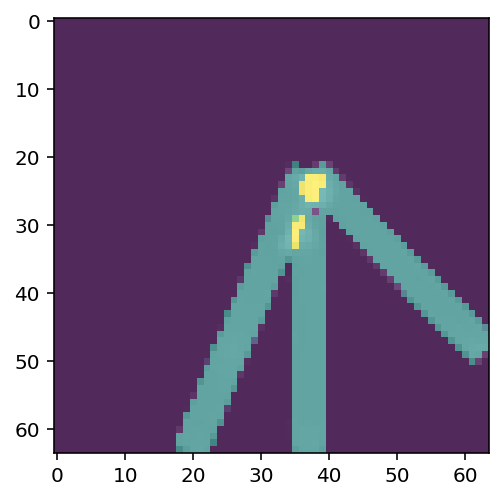

In [22]:
anim = make_animation(aligner.state['raster'][0].detach().cpu().numpy(), aligner.state['renders'])
HTML(anim.to_html5_video())

In [ ]:
np.random.seed(43)
torch.manual_seed(43)

dataloader = DataLoader(syn_dataset, batch_size=32)

perturber = LinePerturbationPipe(
    LineBatchRandomShift((-6, 6), (0, 1)),
)

n_steps = 300

loss = LossComposition()
ot_loss = SamplesLoss("sinkhorn", p=2, blur=.05, scaling=.6, reach=6.)
loss.add(make_default_loss_fn(bce_schedule=(lambda state: 0.0), ot_loss=ot_loss))
loss.add(not_too_thin)
# loss.add(perceptual_bce(model, 3))
# loss.add(perceptual_bce(model, 4))

aligner = None

for i, batch in enumerate(dataloader):
    vectors = perturber.transform(batch['vector'][PrimitiveType.PT_LINE].type(torch.float32)).to(DEVICE)
    vectors[:, :, 5] = 0.5
    
    rasters = 1. - batch['raster'].to(DEVICE)
    rasters = model.forward(rasters.unsqueeze(1)).squeeze(1).detach()
    rasters /= rasters.max(dim=2, keepdim=True).values.max(dim=1, keepdim=True).values
    
    grad_transformer = compose(strip_confidence_grads, coords_only_grads(n_steps - 100))
    
    aligner = StatefulBatchAligner(vectors, rasters, device=DEVICE)
    init_ot_aligner(aligner, loss_fn=loss, device=DEVICE,
                    optimize_fn=make_default_optimize_fn(
                        aligner, 
                        lr=0.25, 
                        transform_grads=grad_transformer,
                        base_optimizer=optim.Adam,
                    ))
    
    aligner.add_callback(store_render_difference)
    aligner.add_callback(accumulate_renders)
    
    for _ in tqdm(range(n_steps)):
        aligner.step()
    
    if i == 0:
        break

 17%|█▋        | 50/300 [00:37<03:14,  1.28it/s]

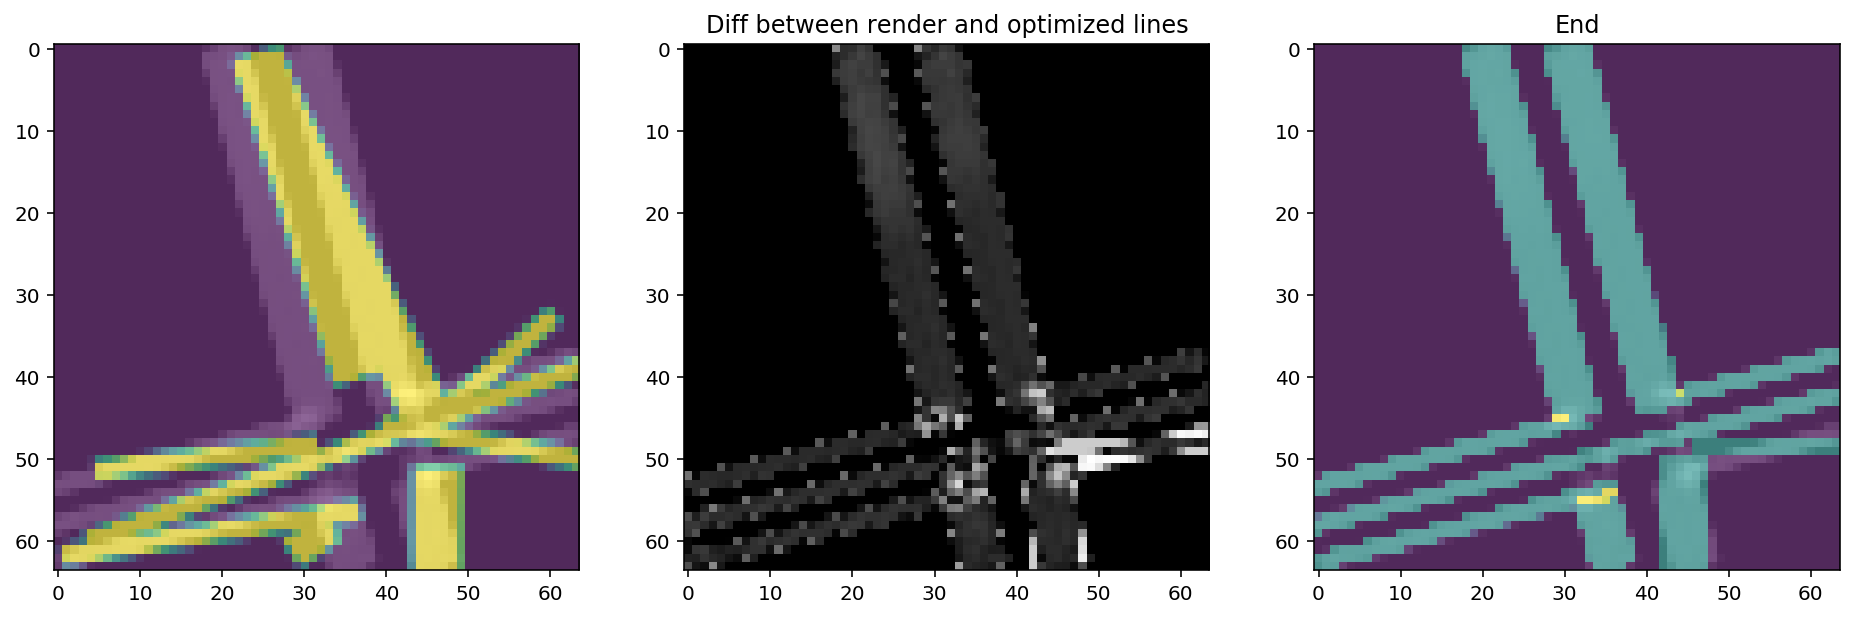

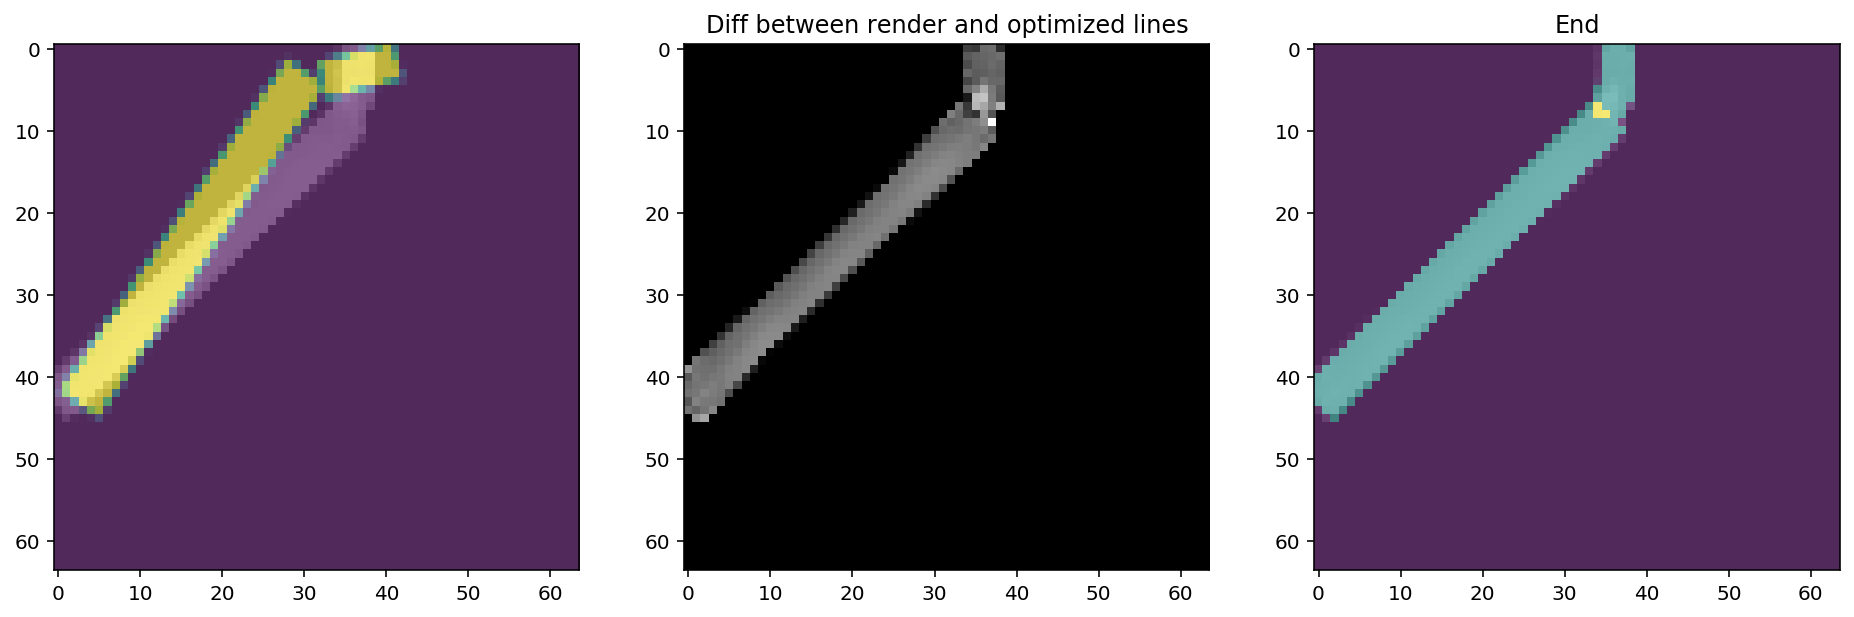

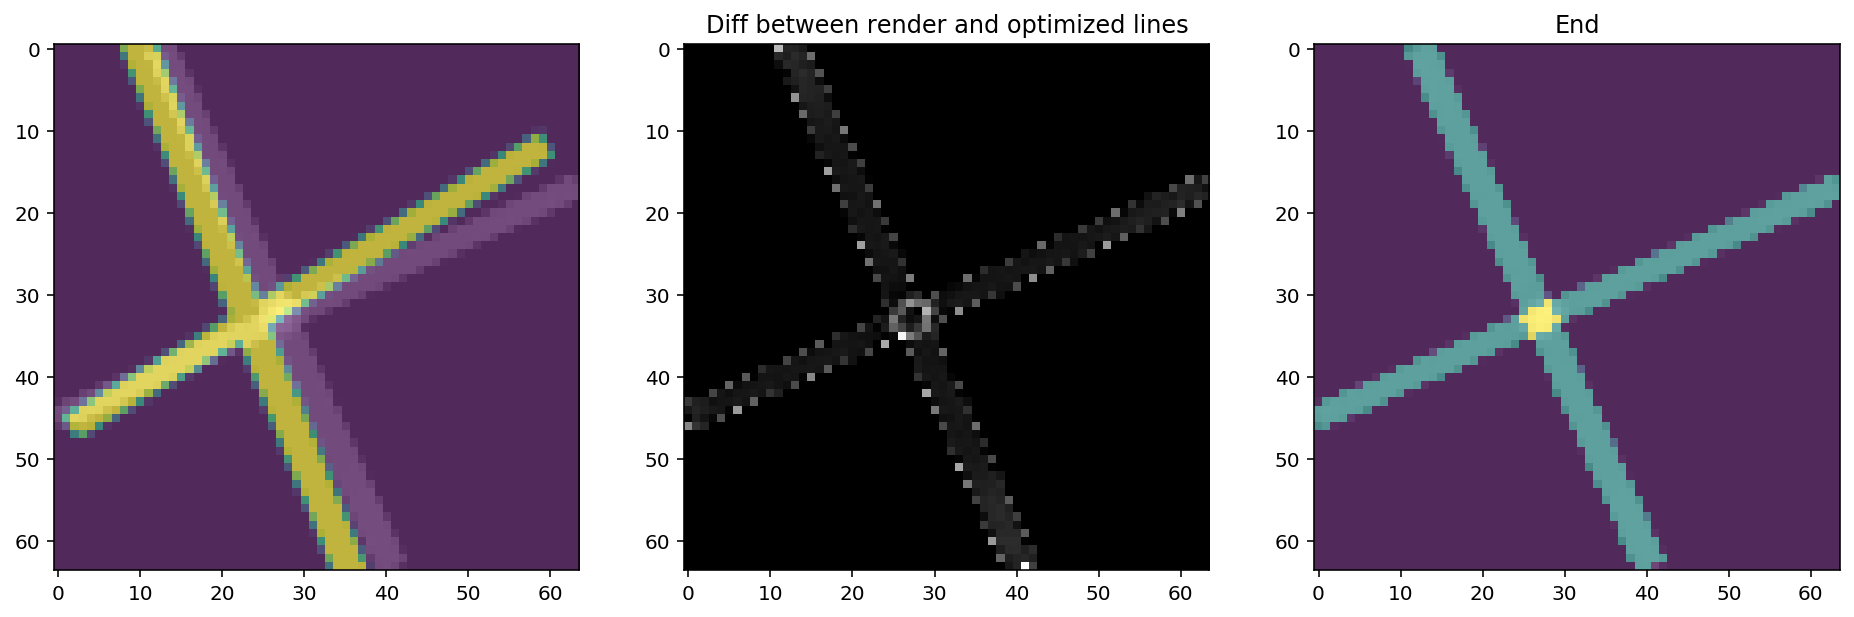

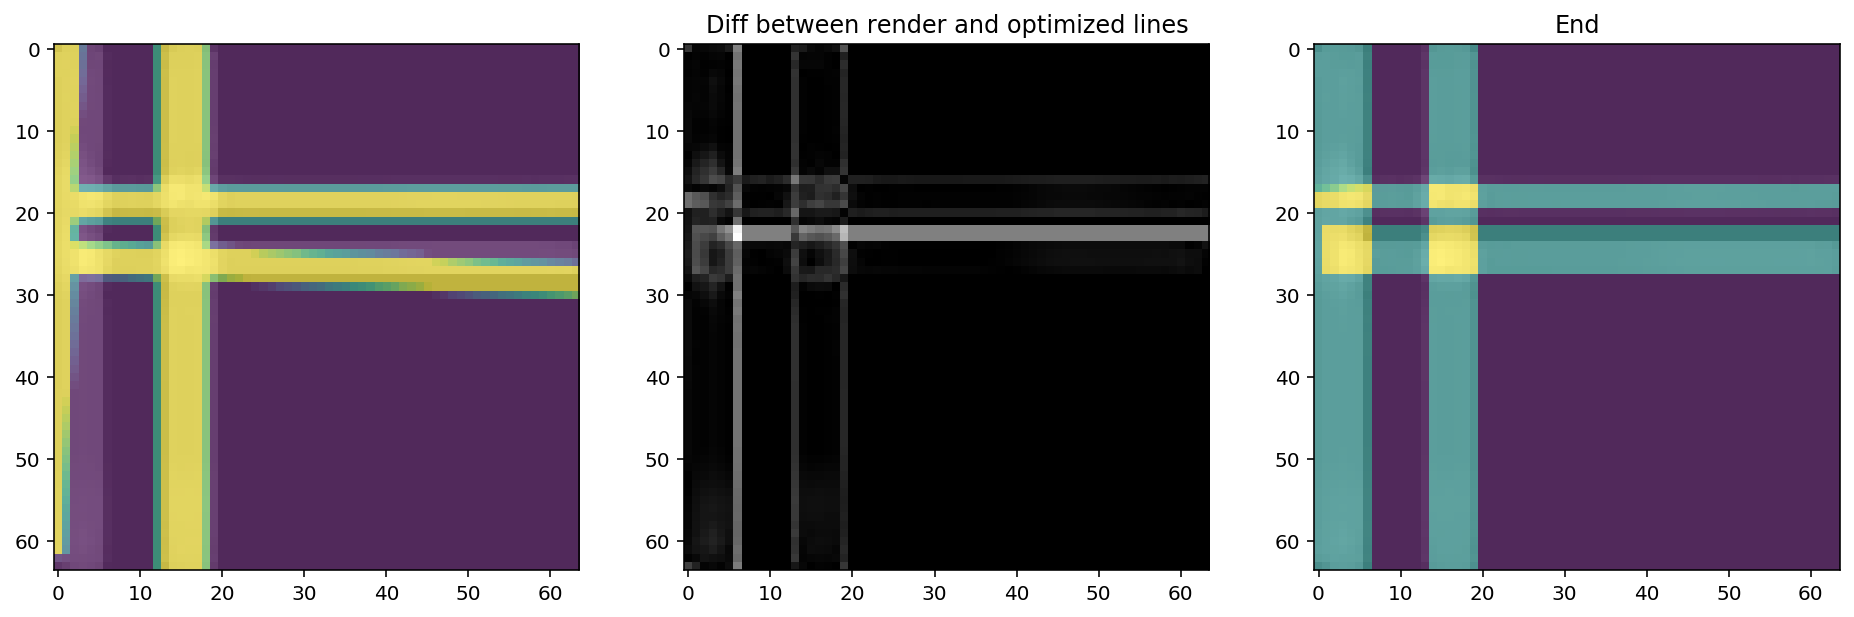

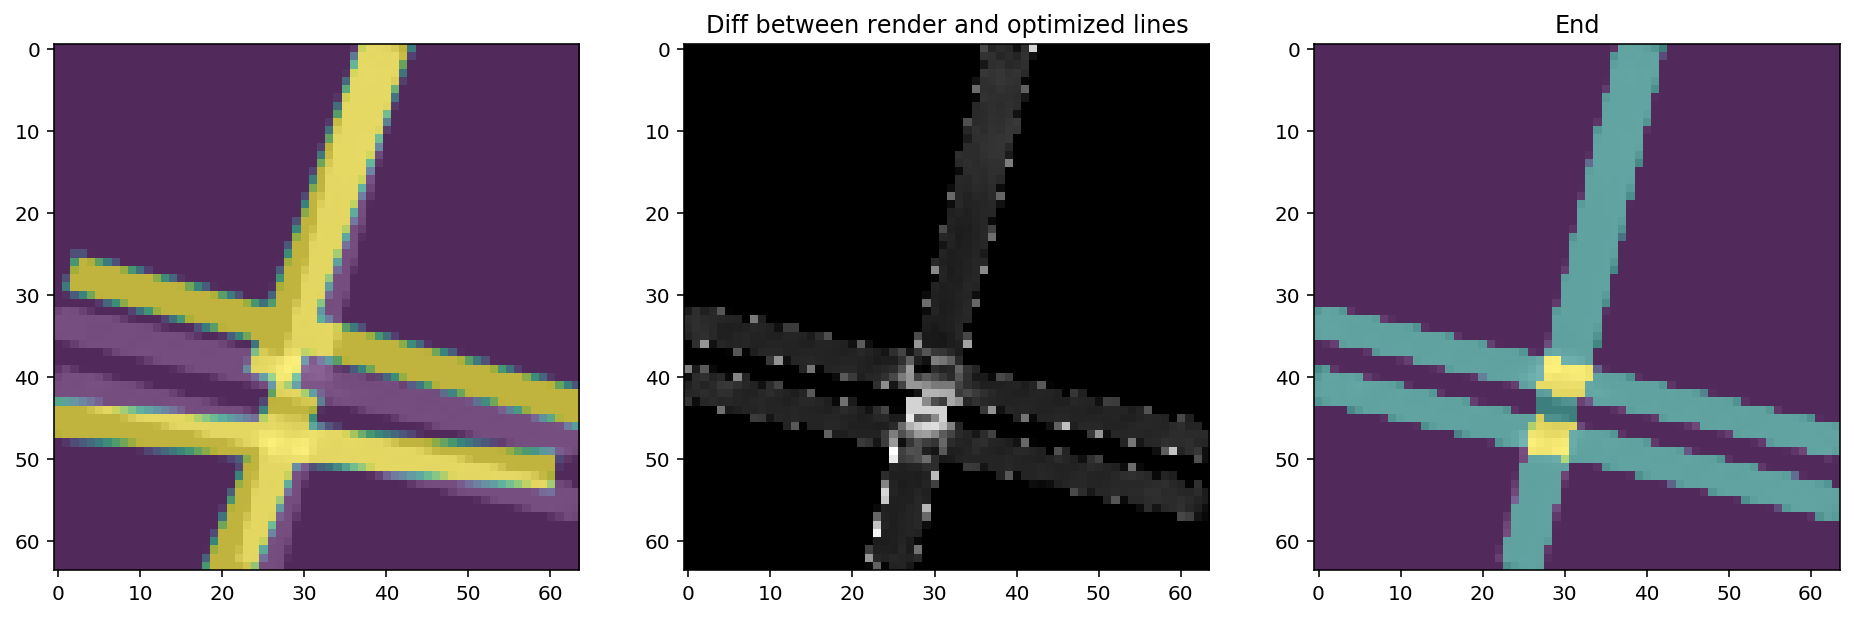

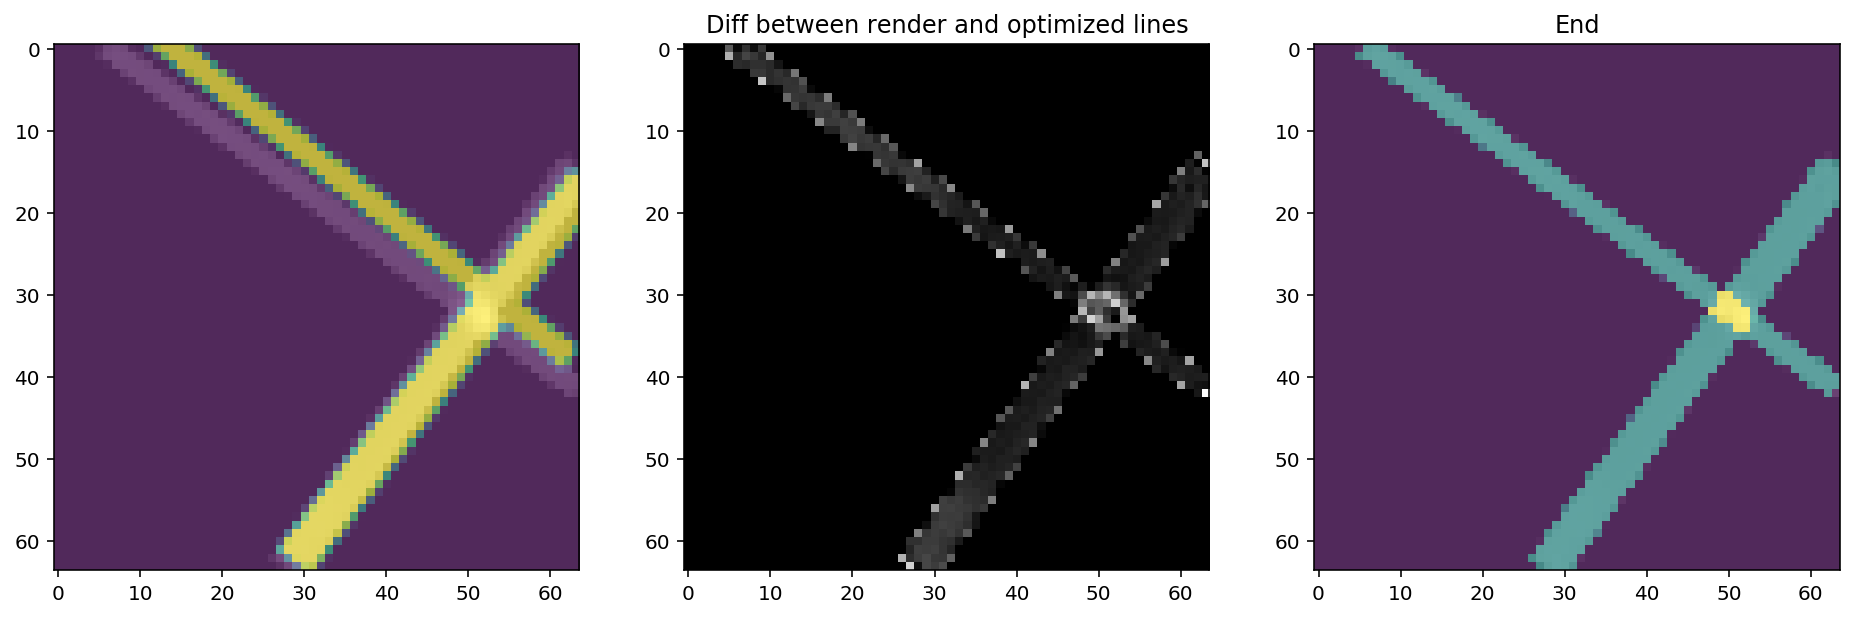

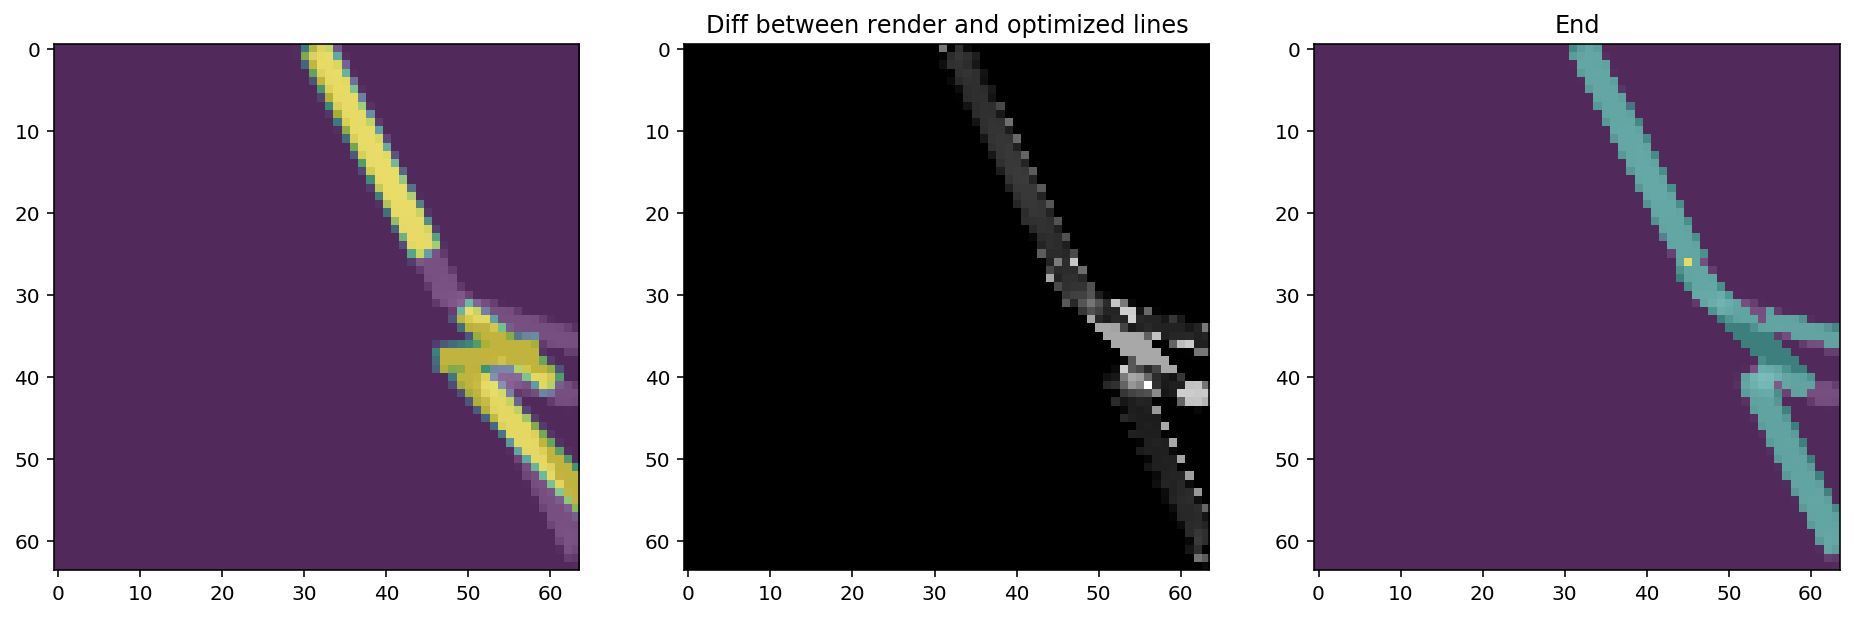

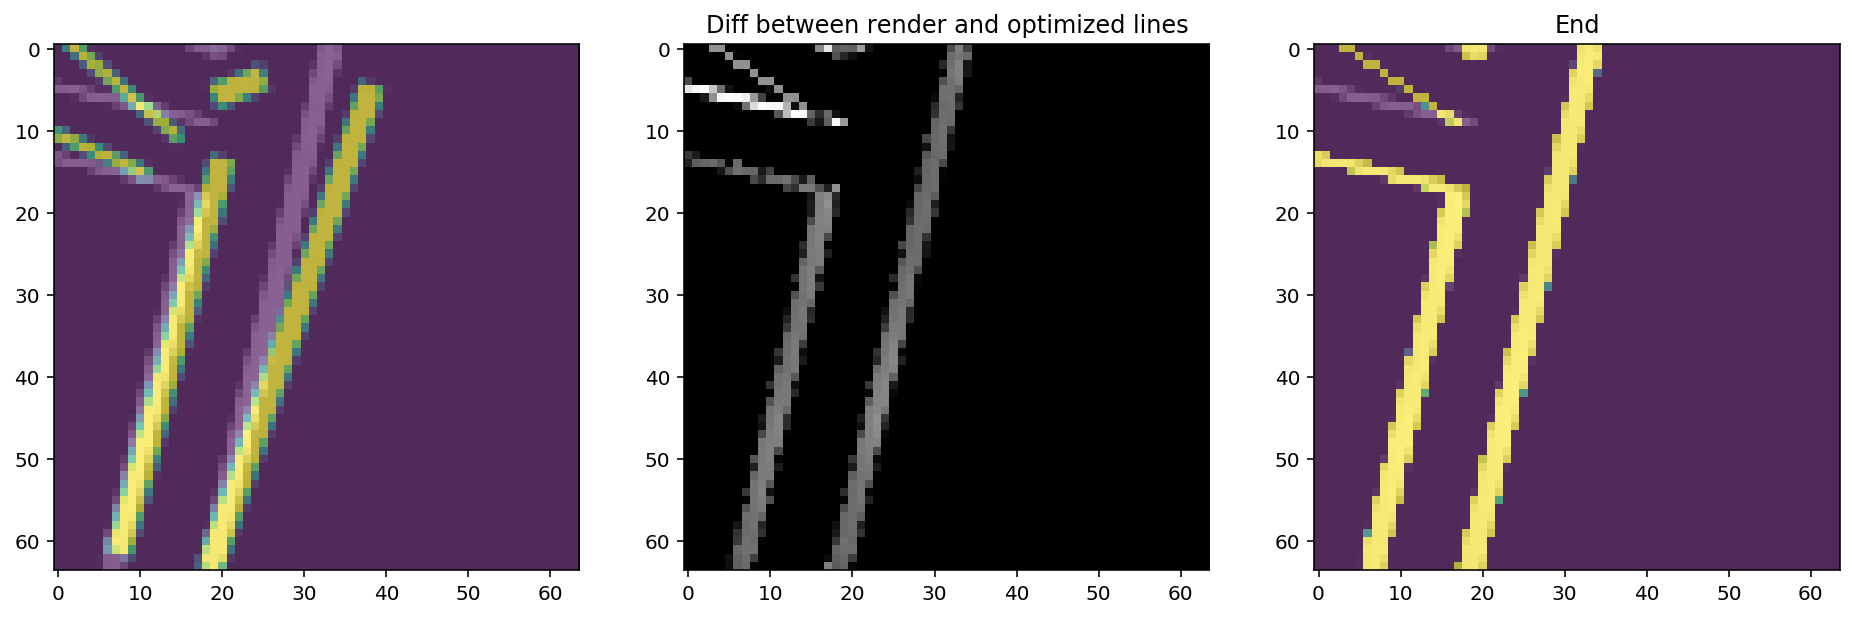

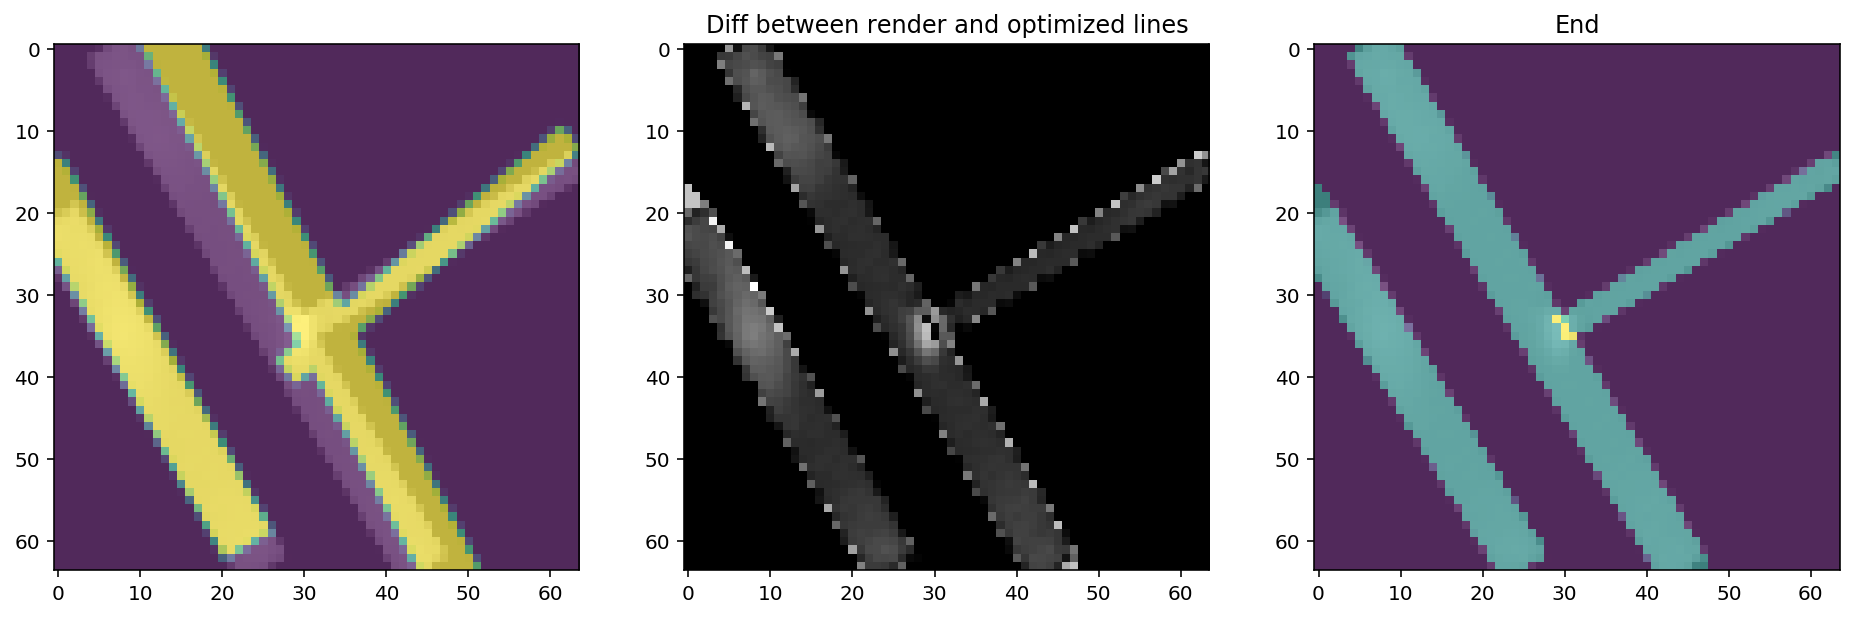

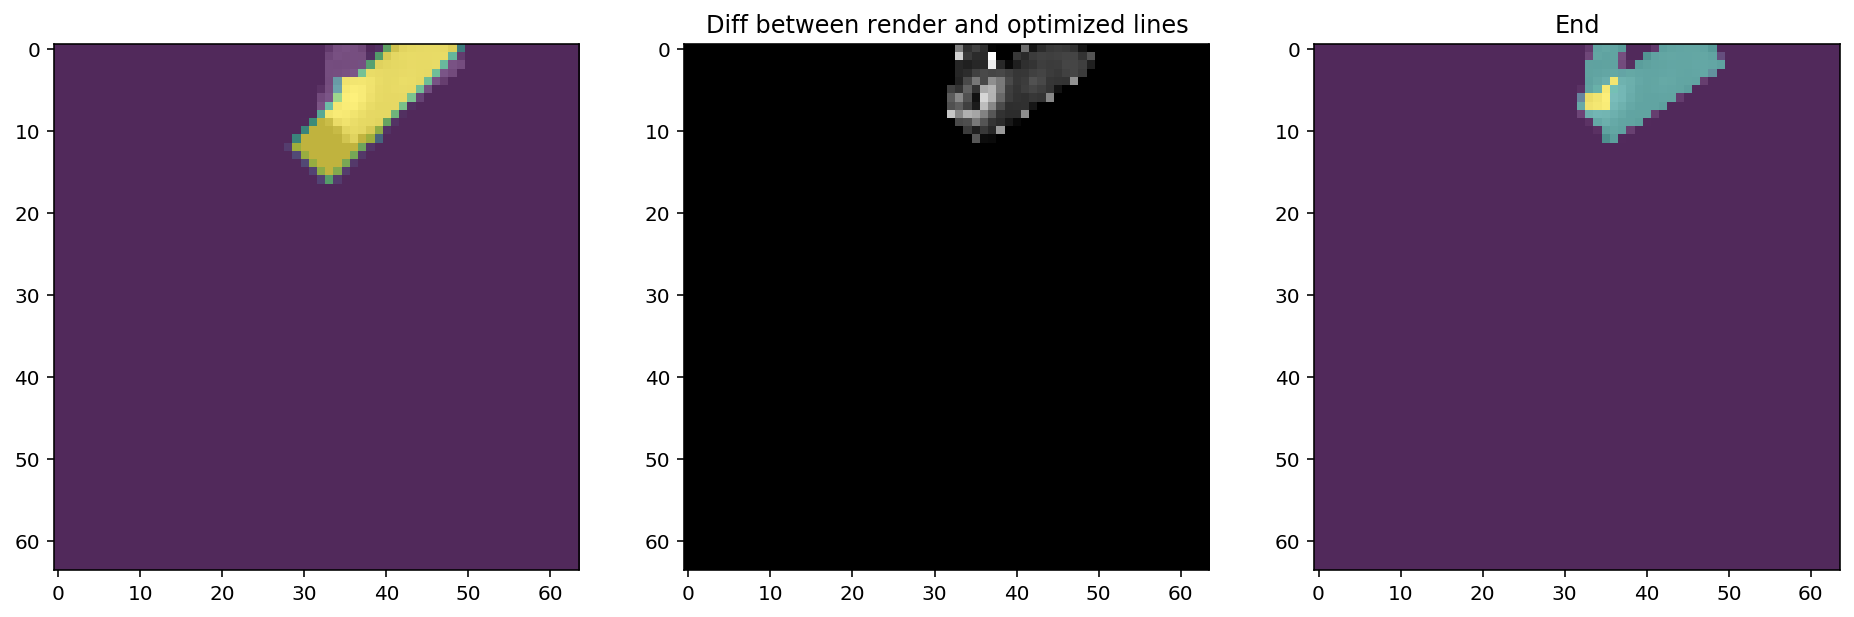

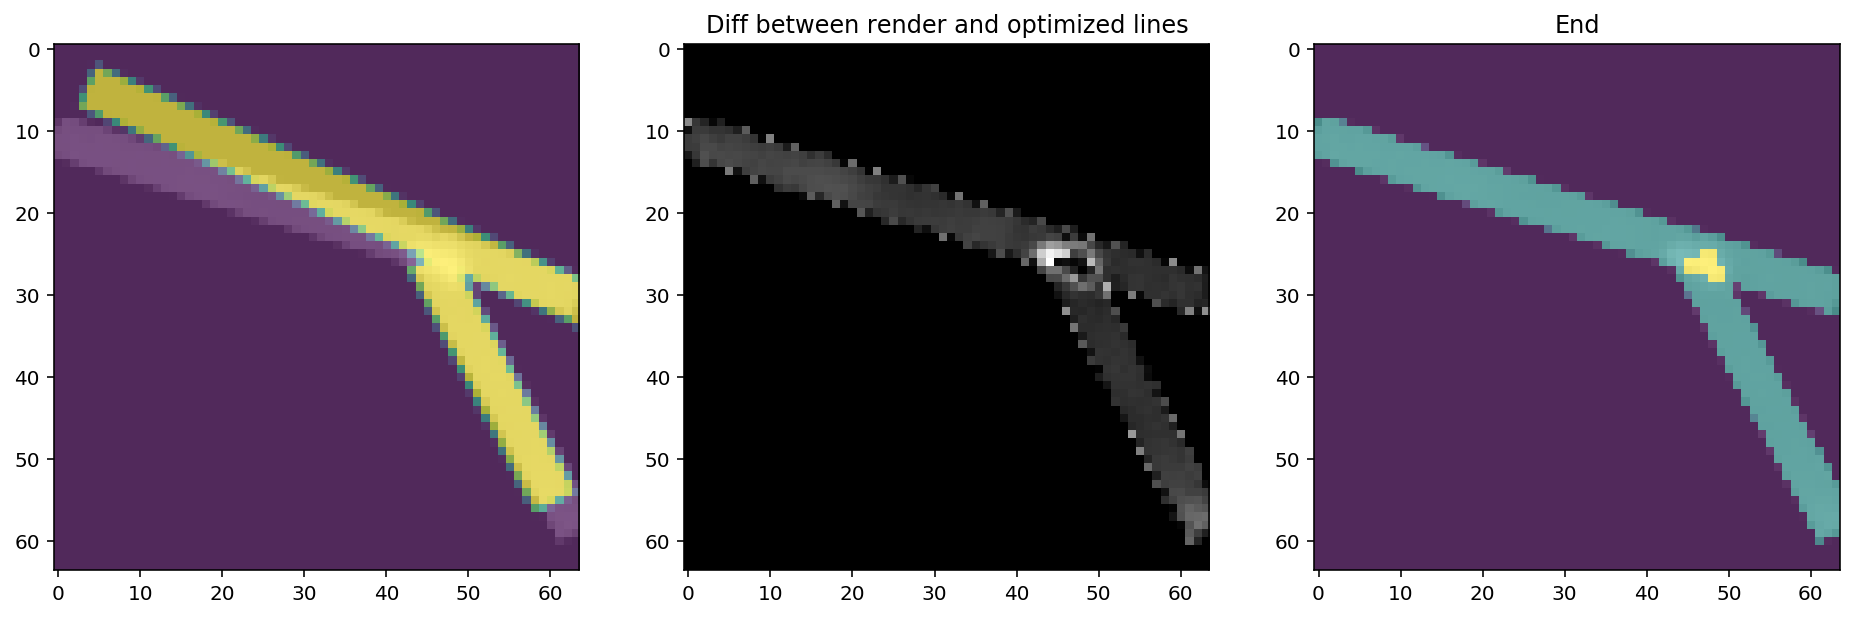

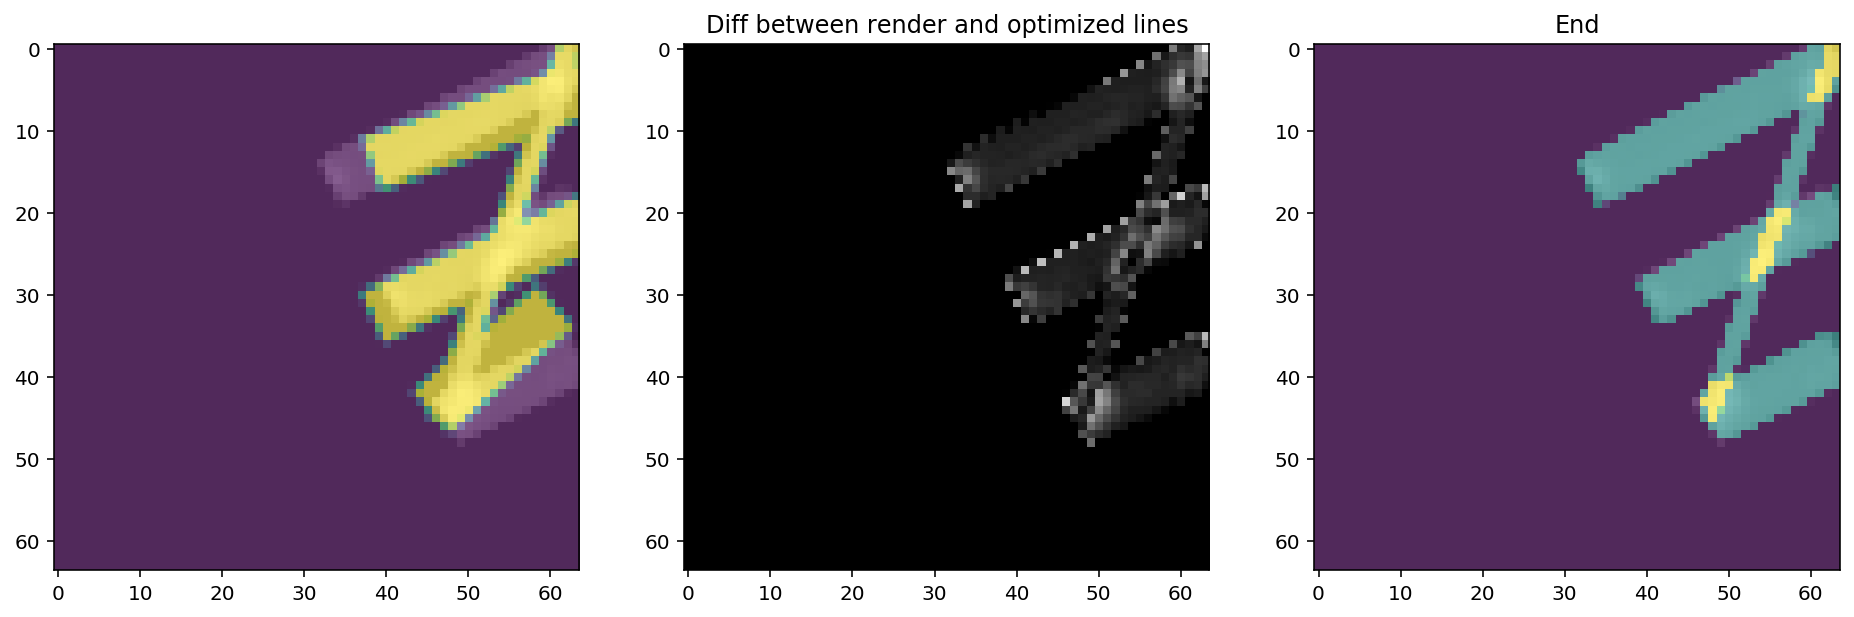

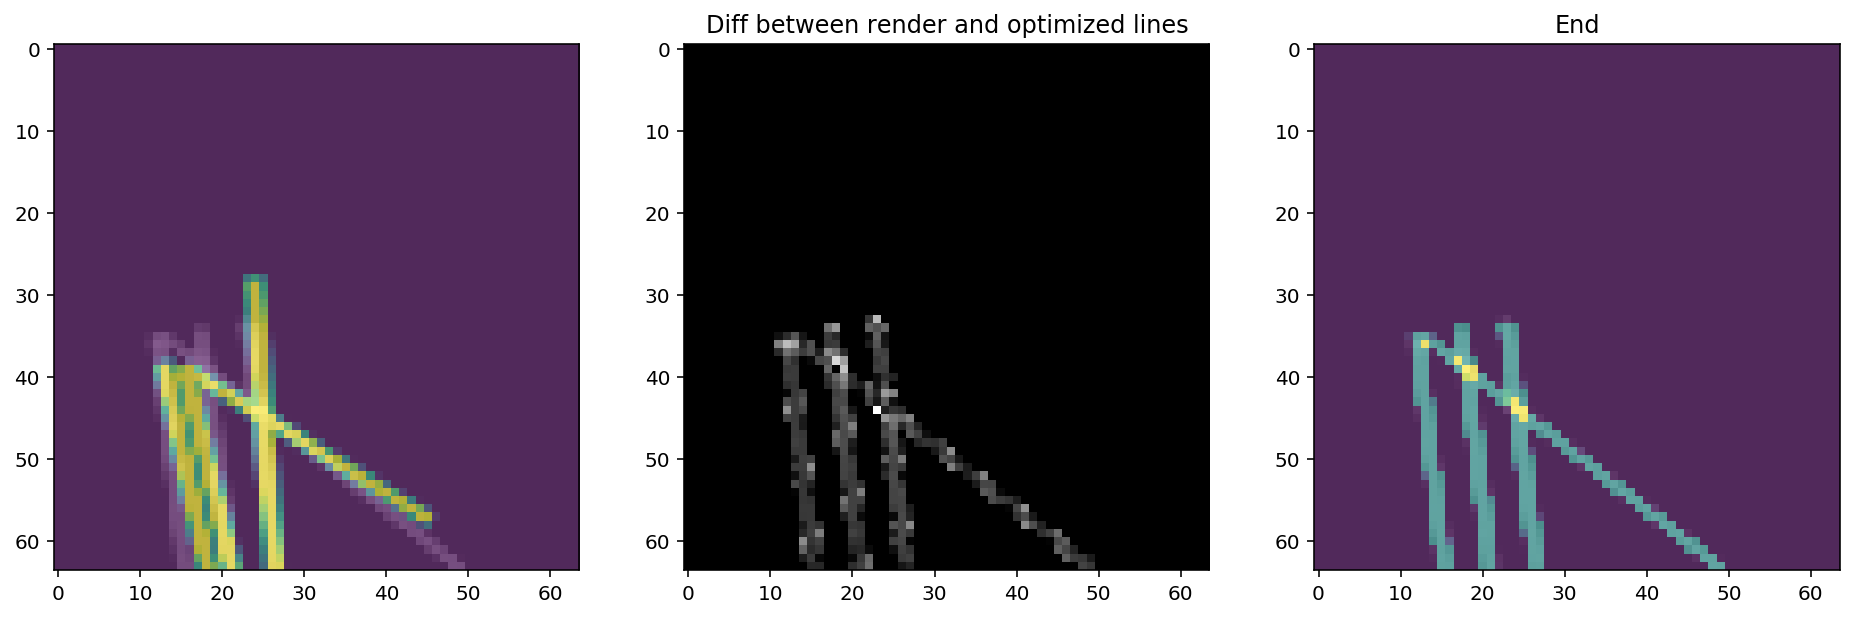

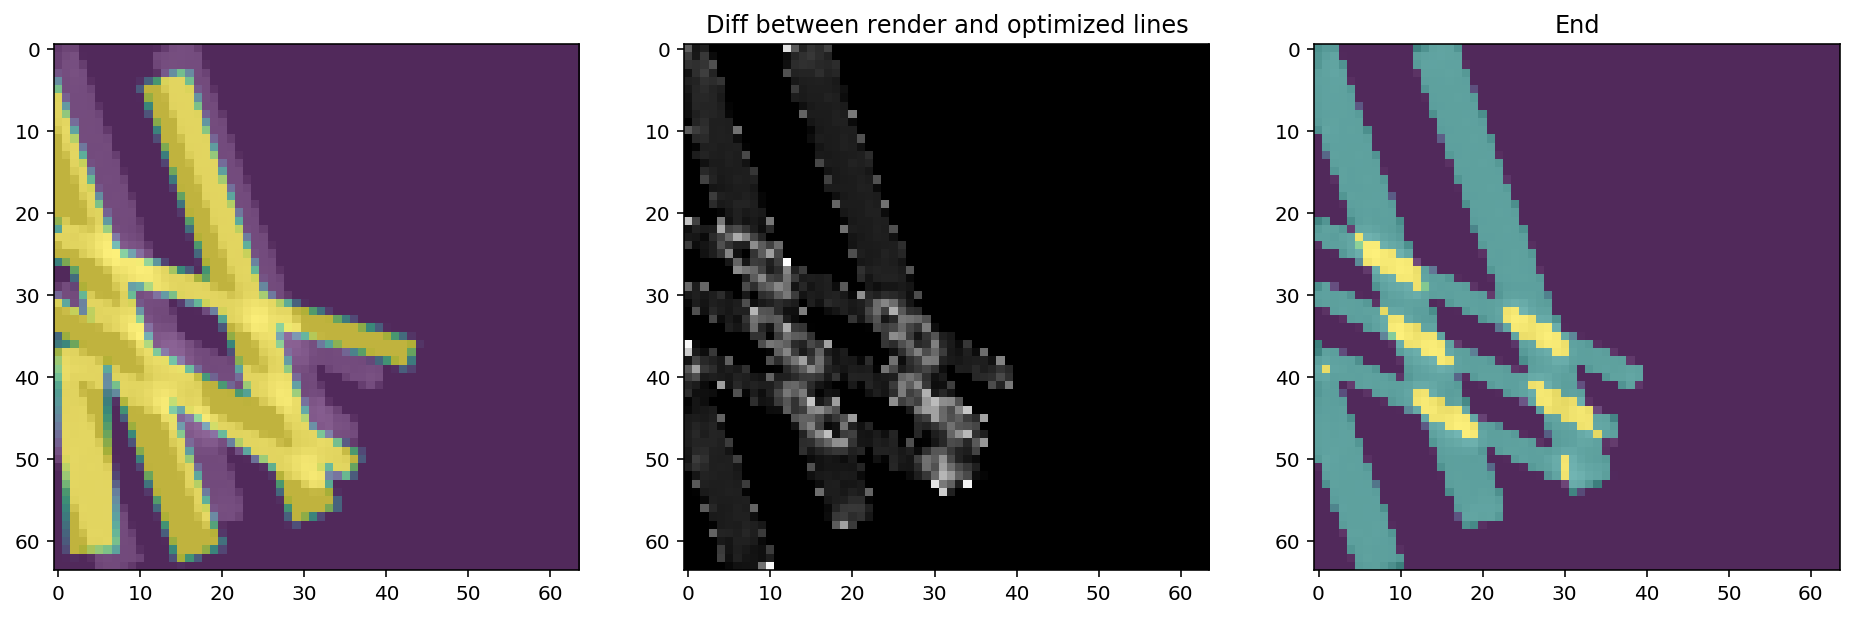

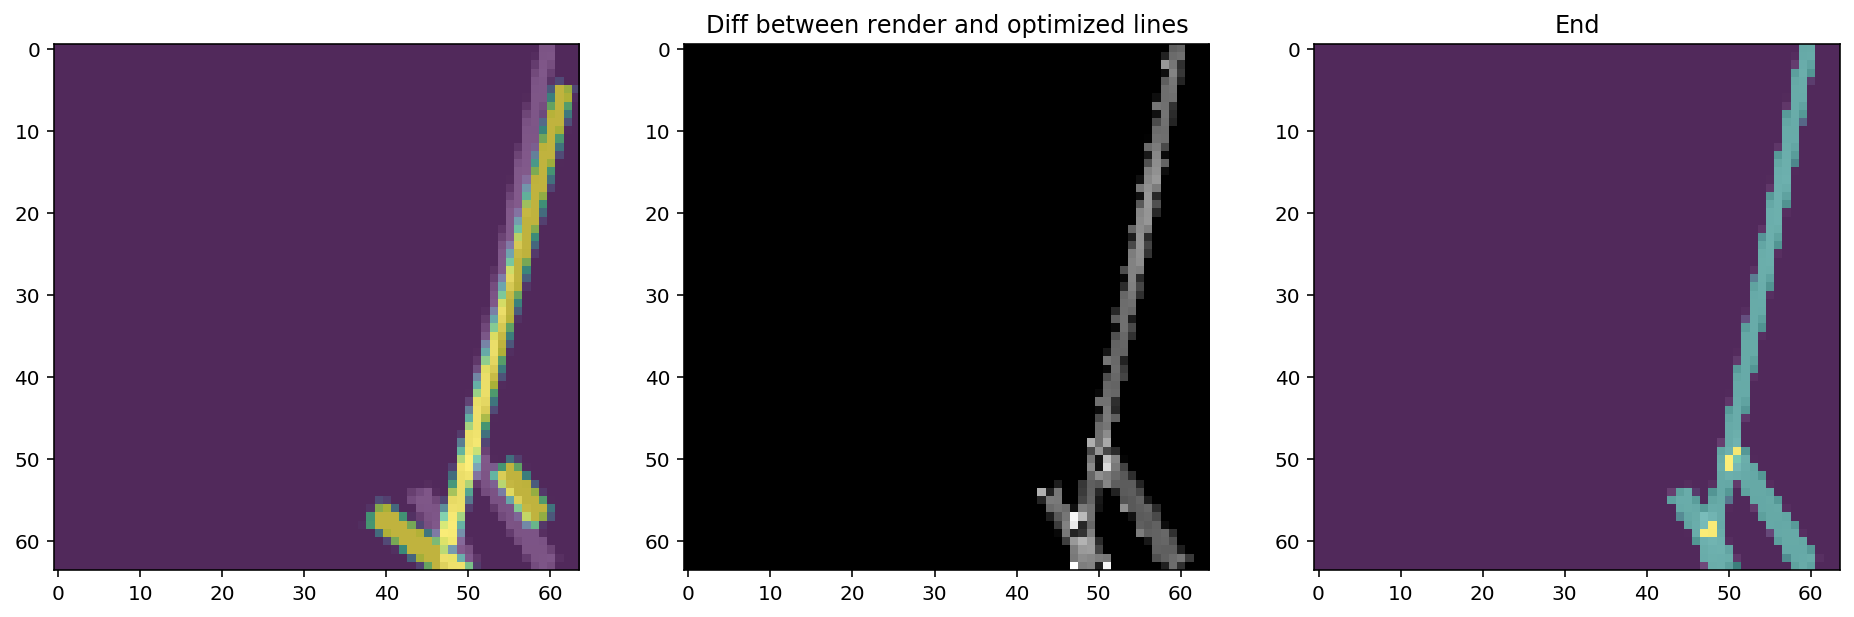

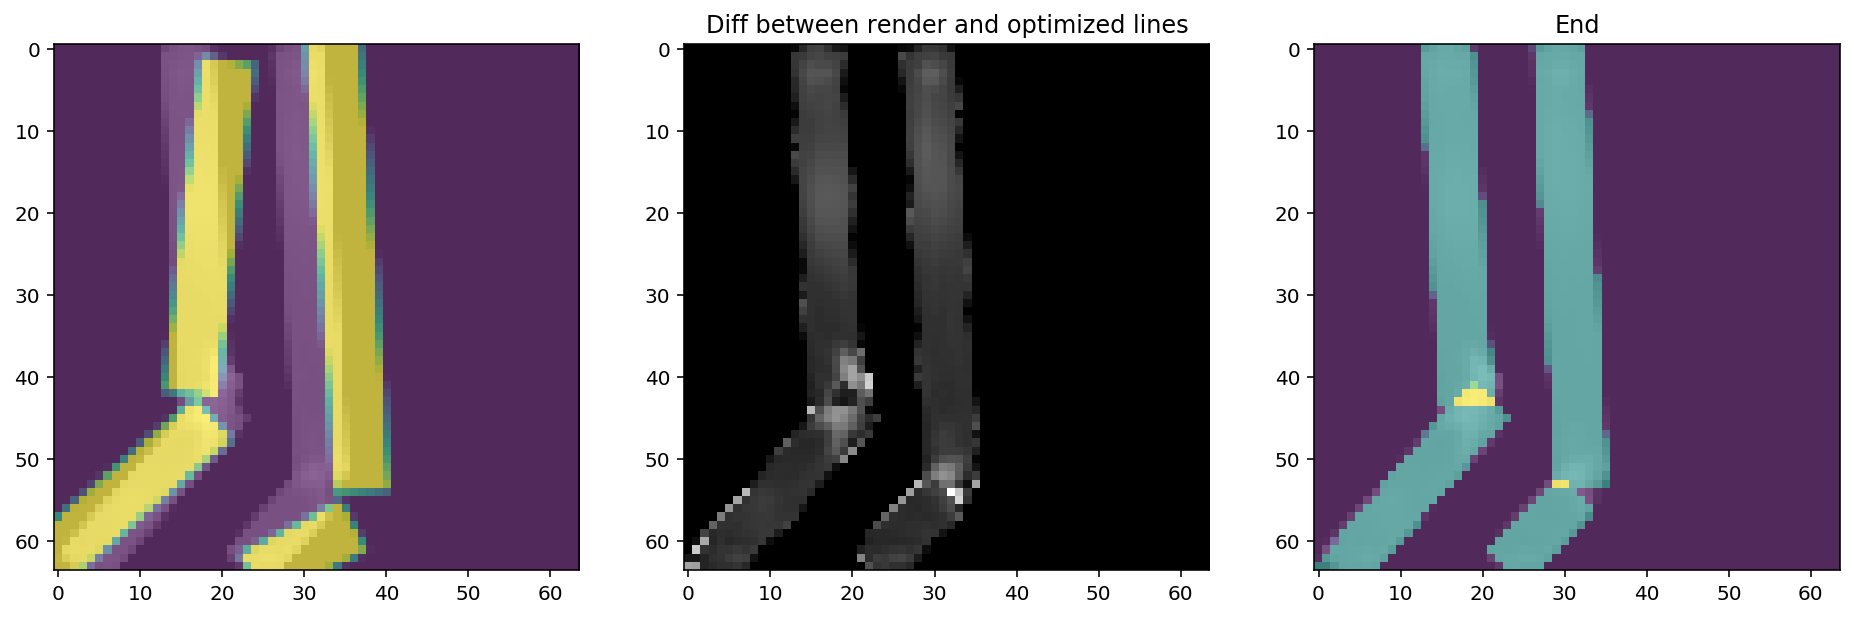

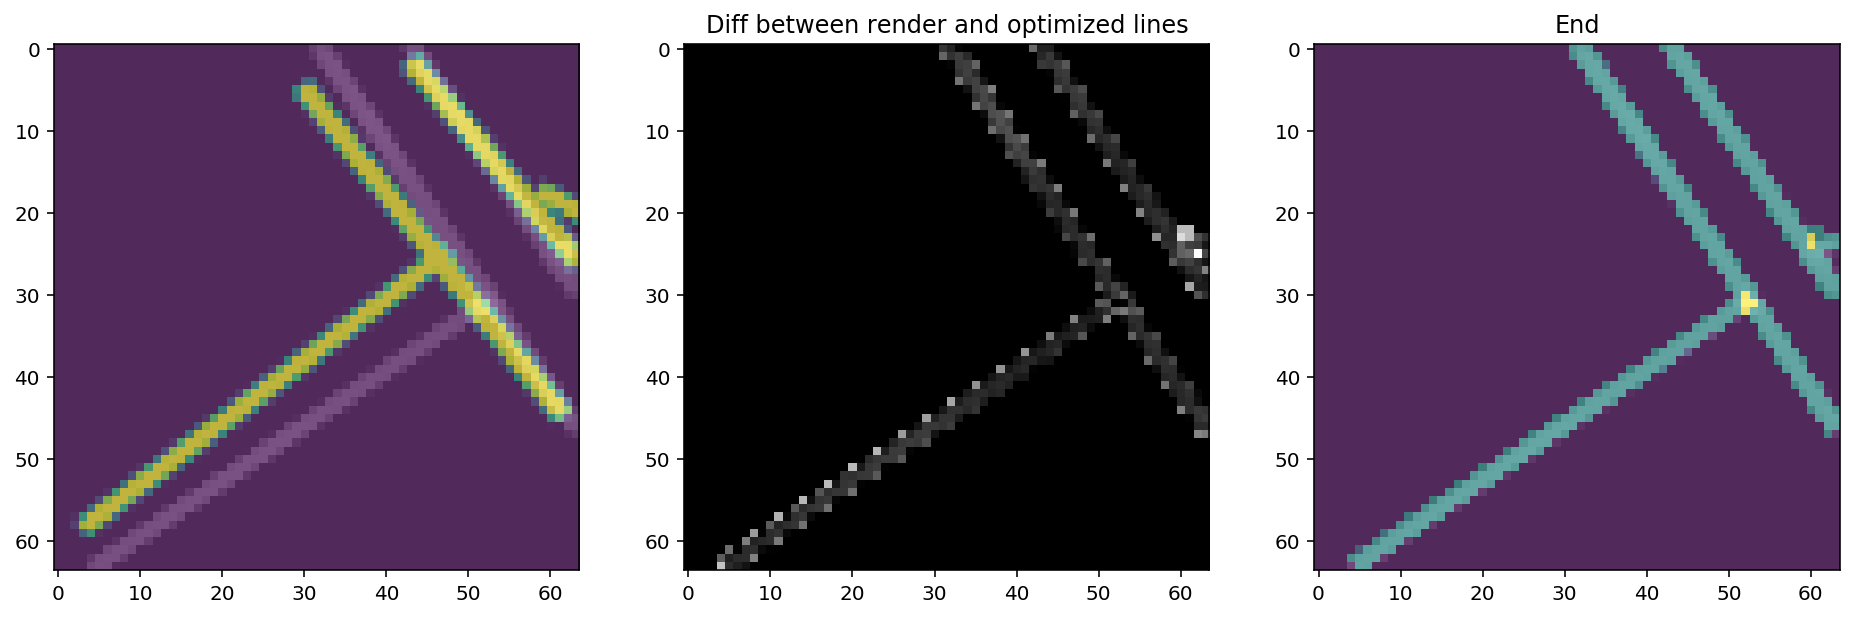

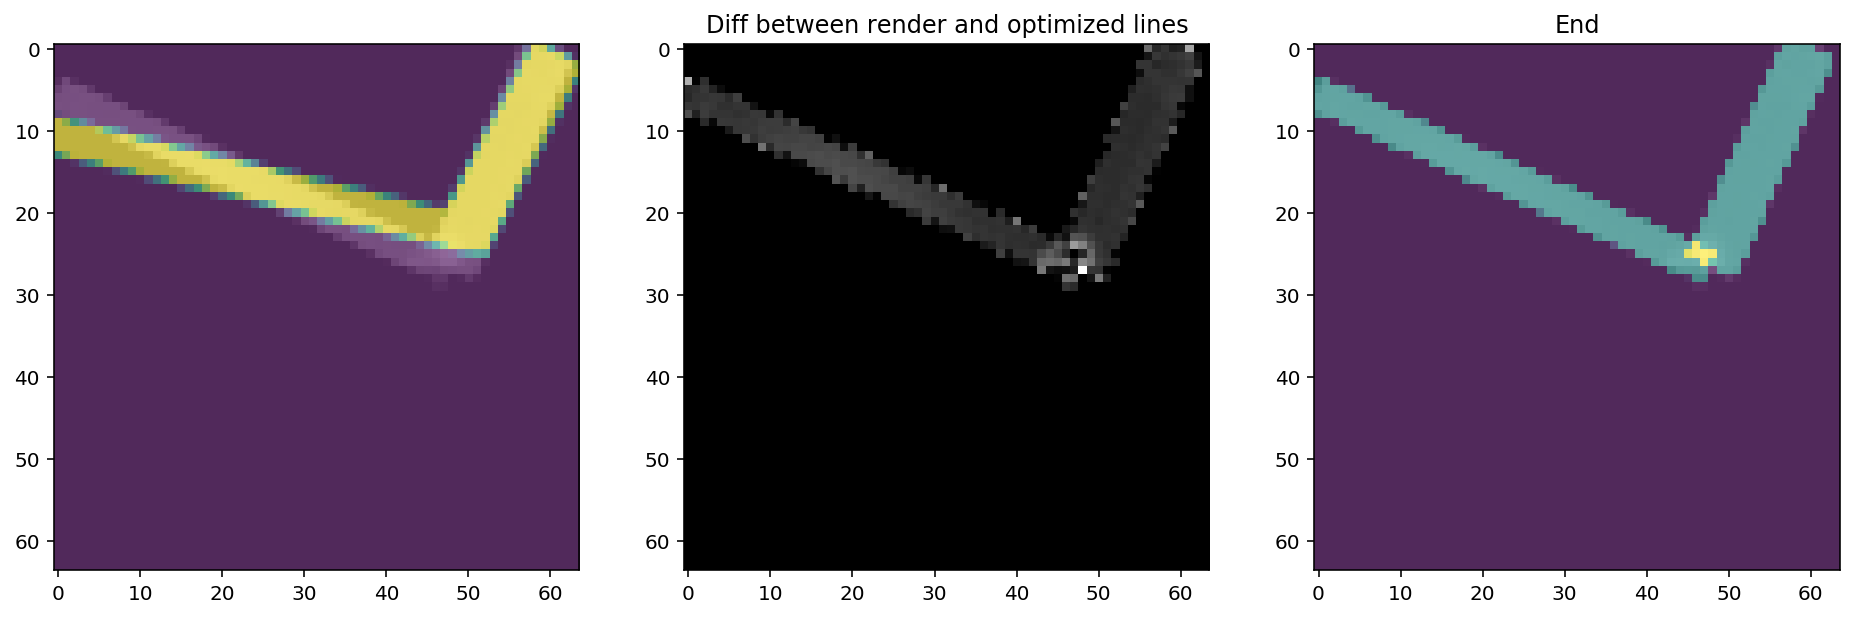

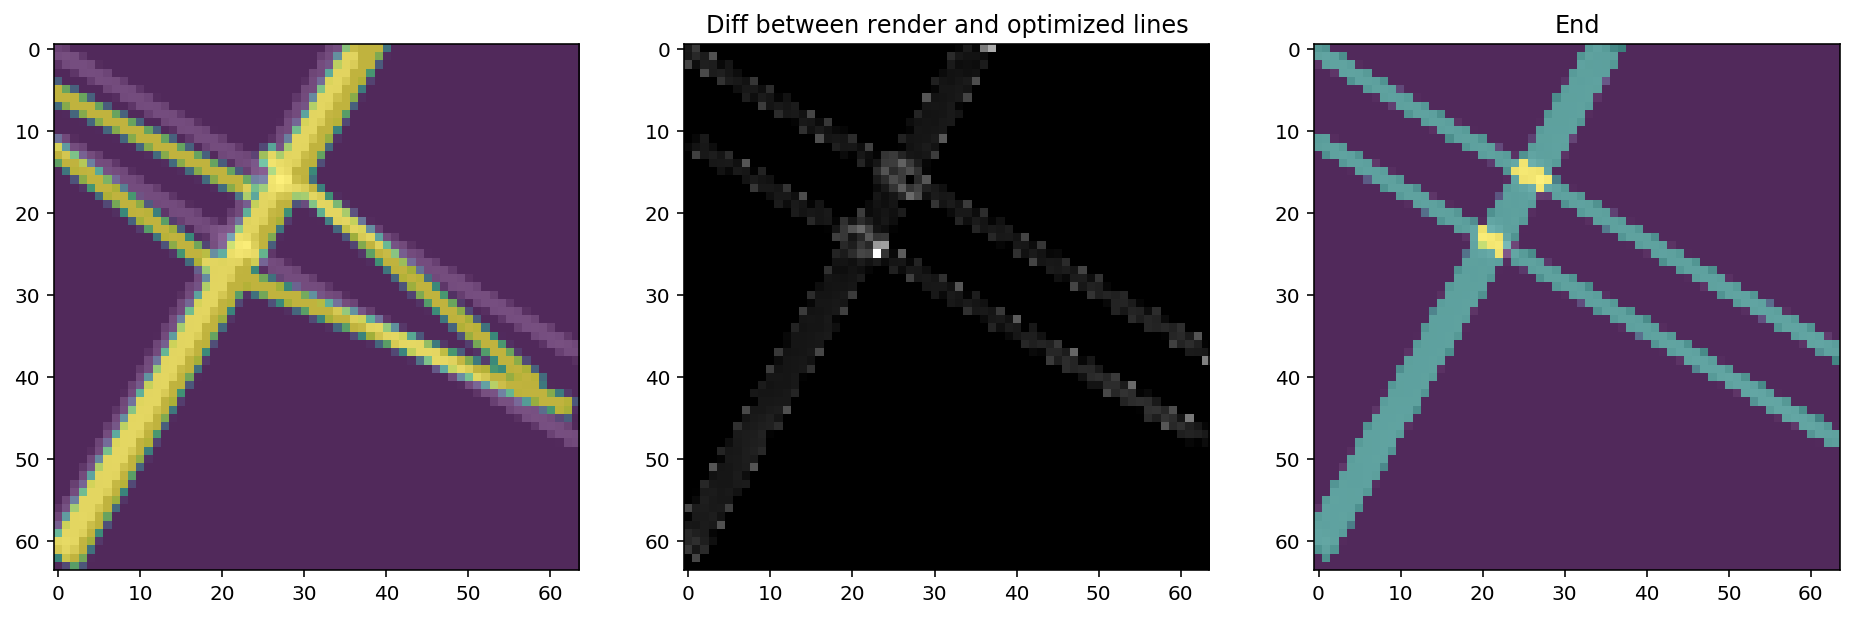

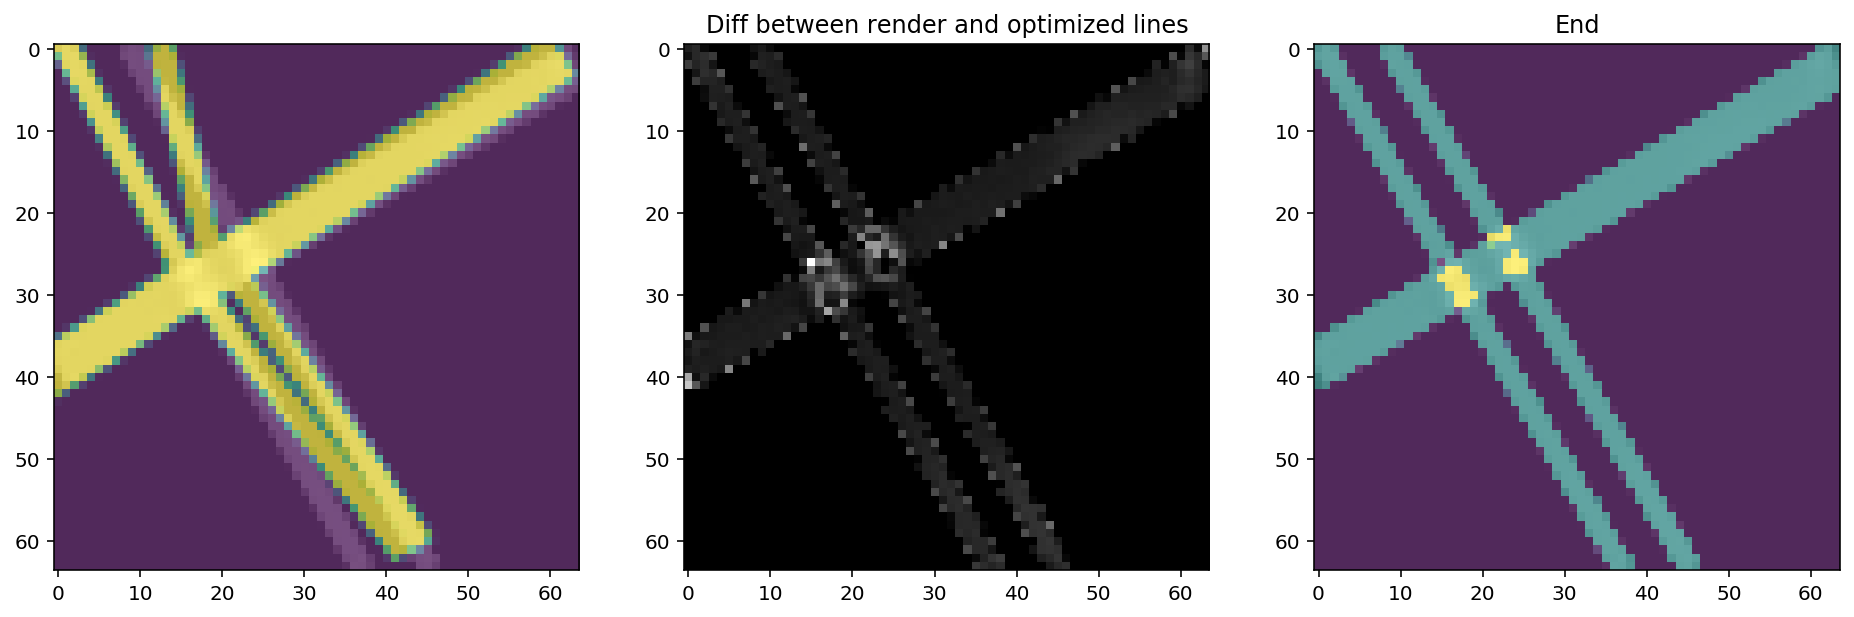

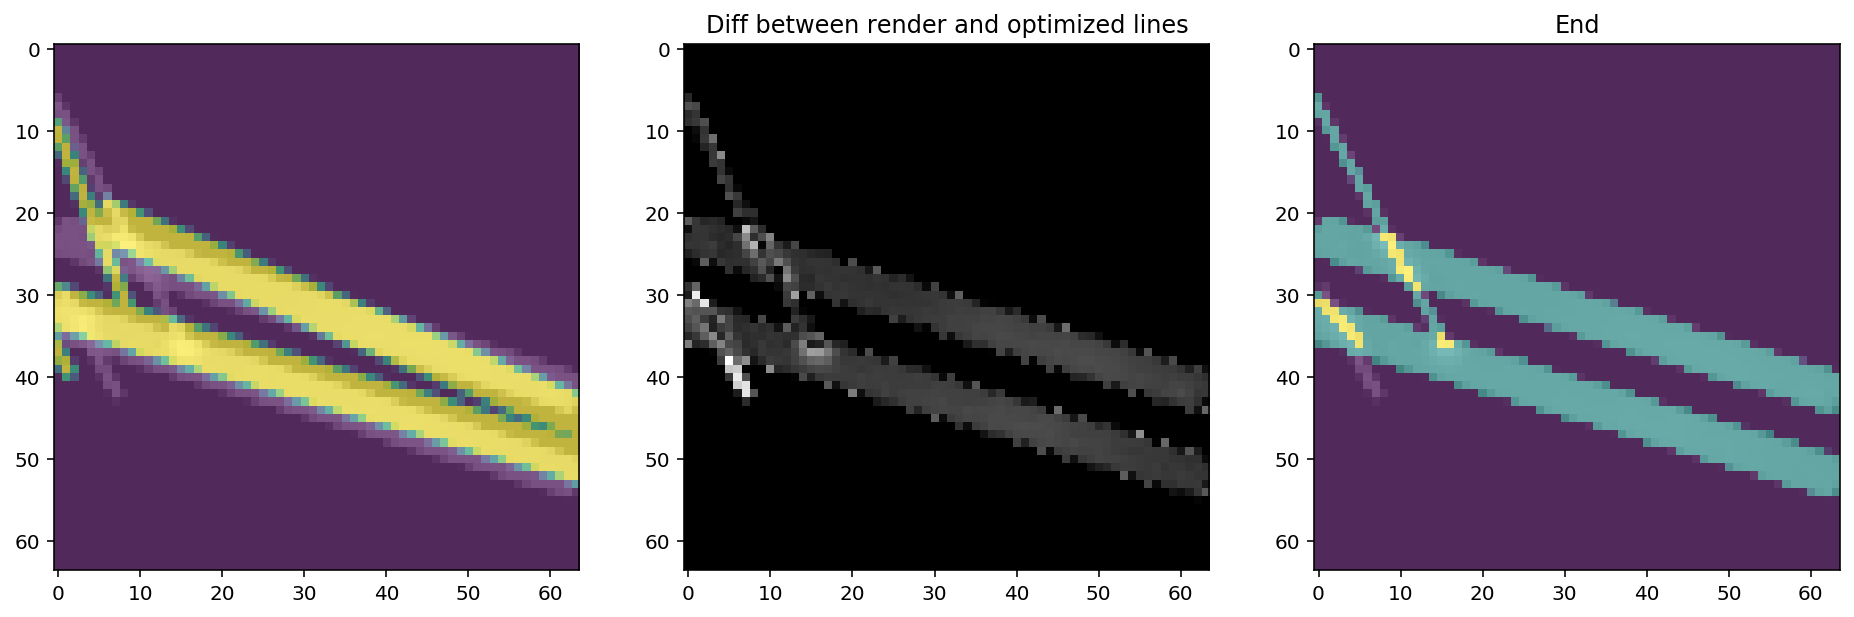

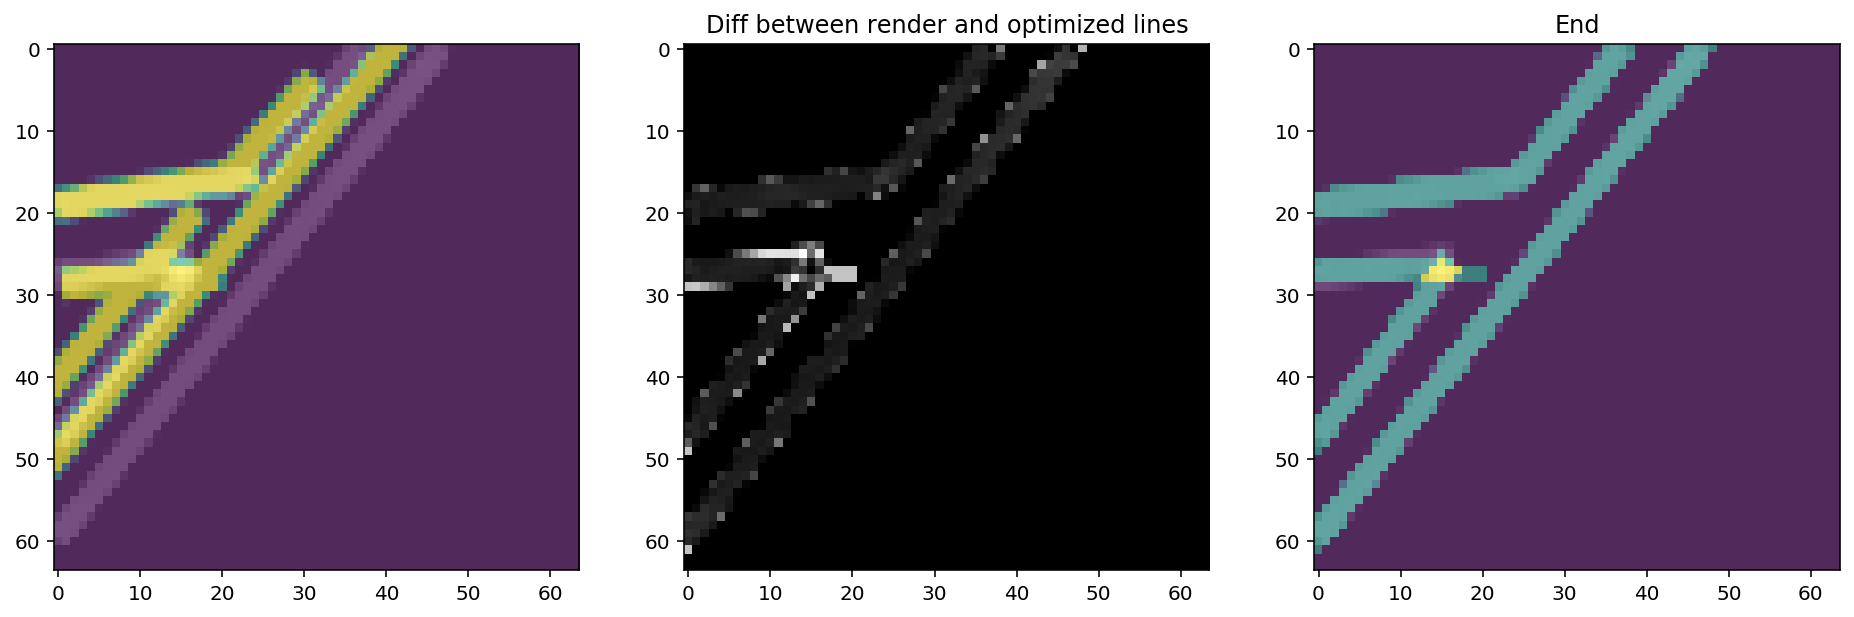

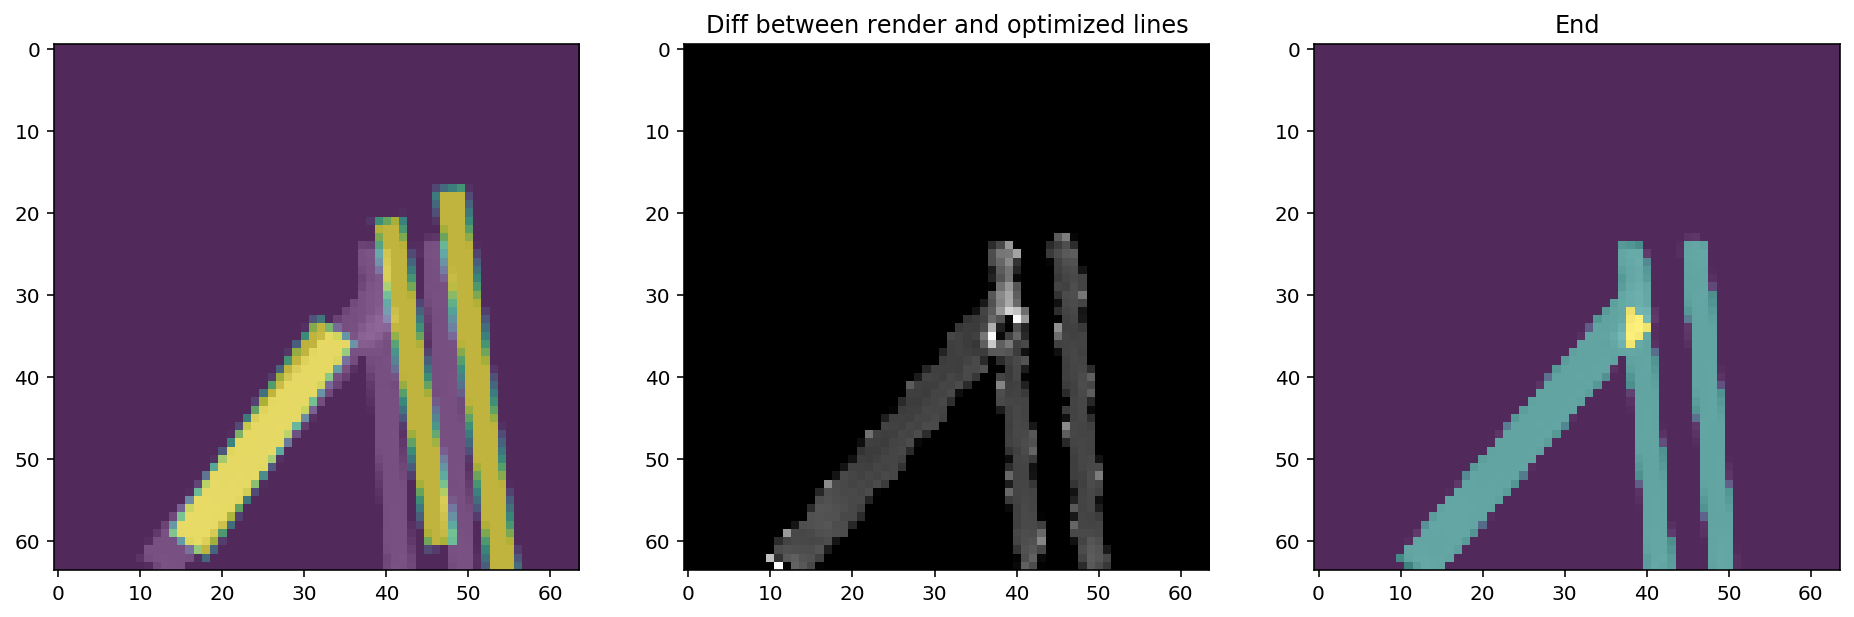

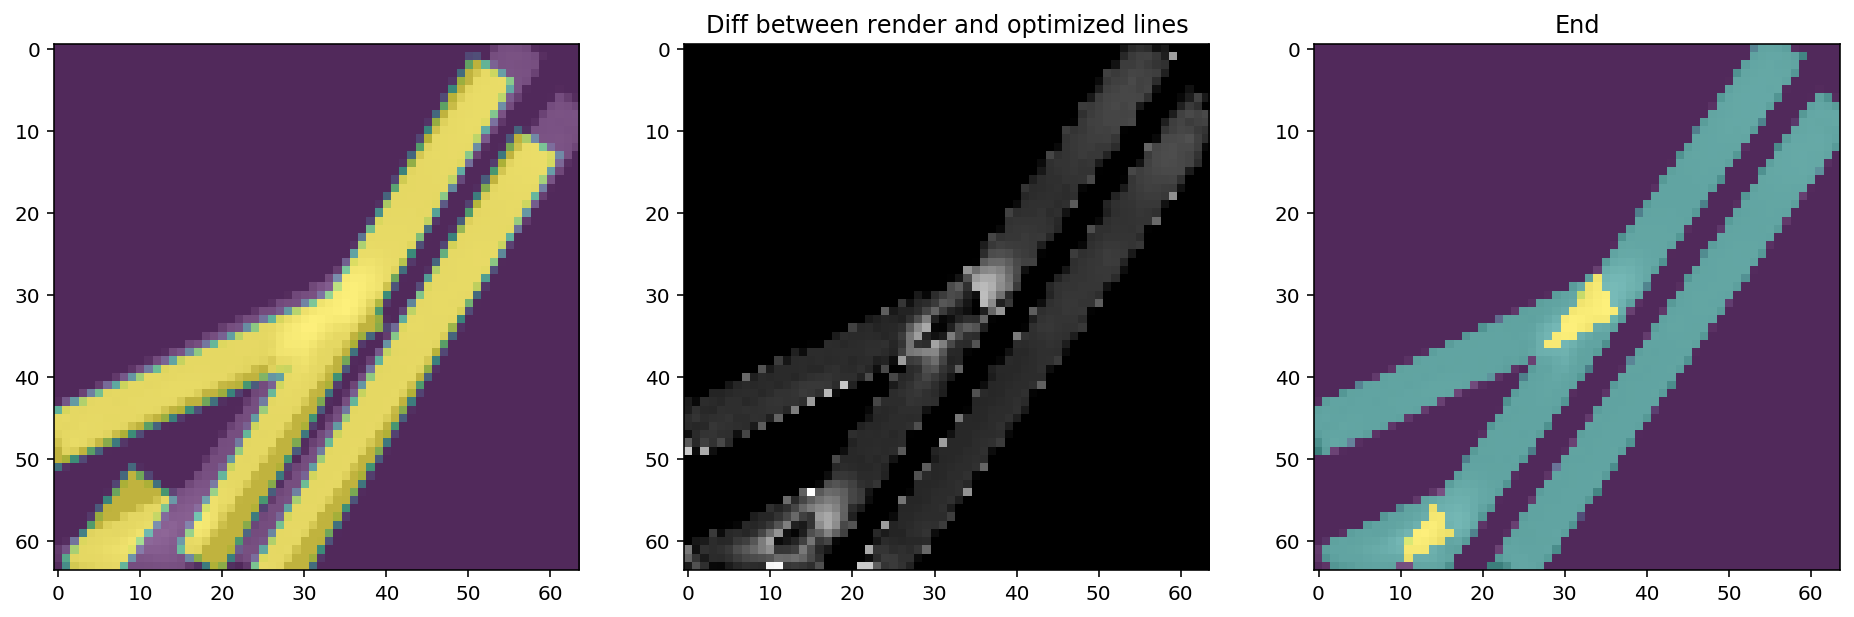

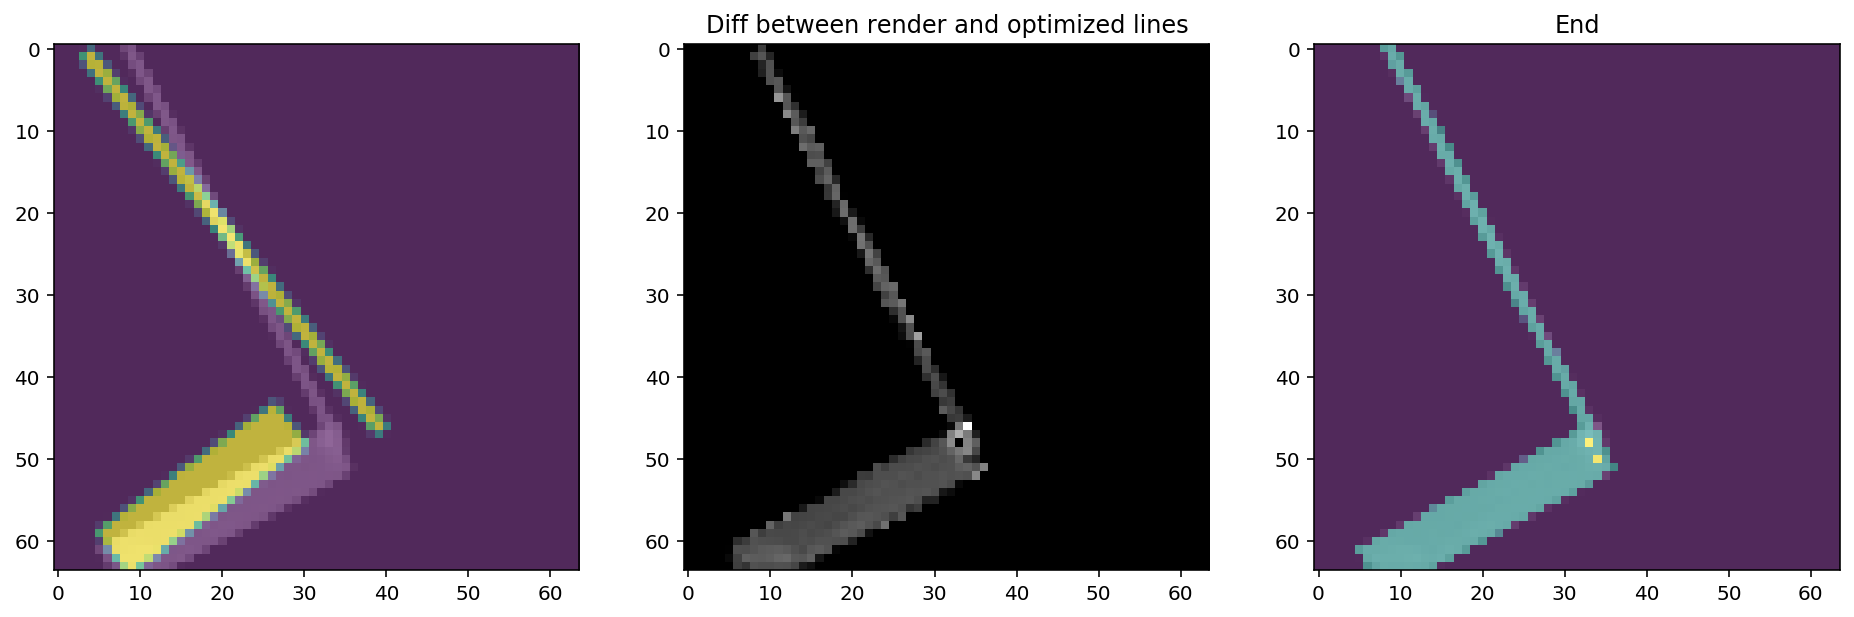

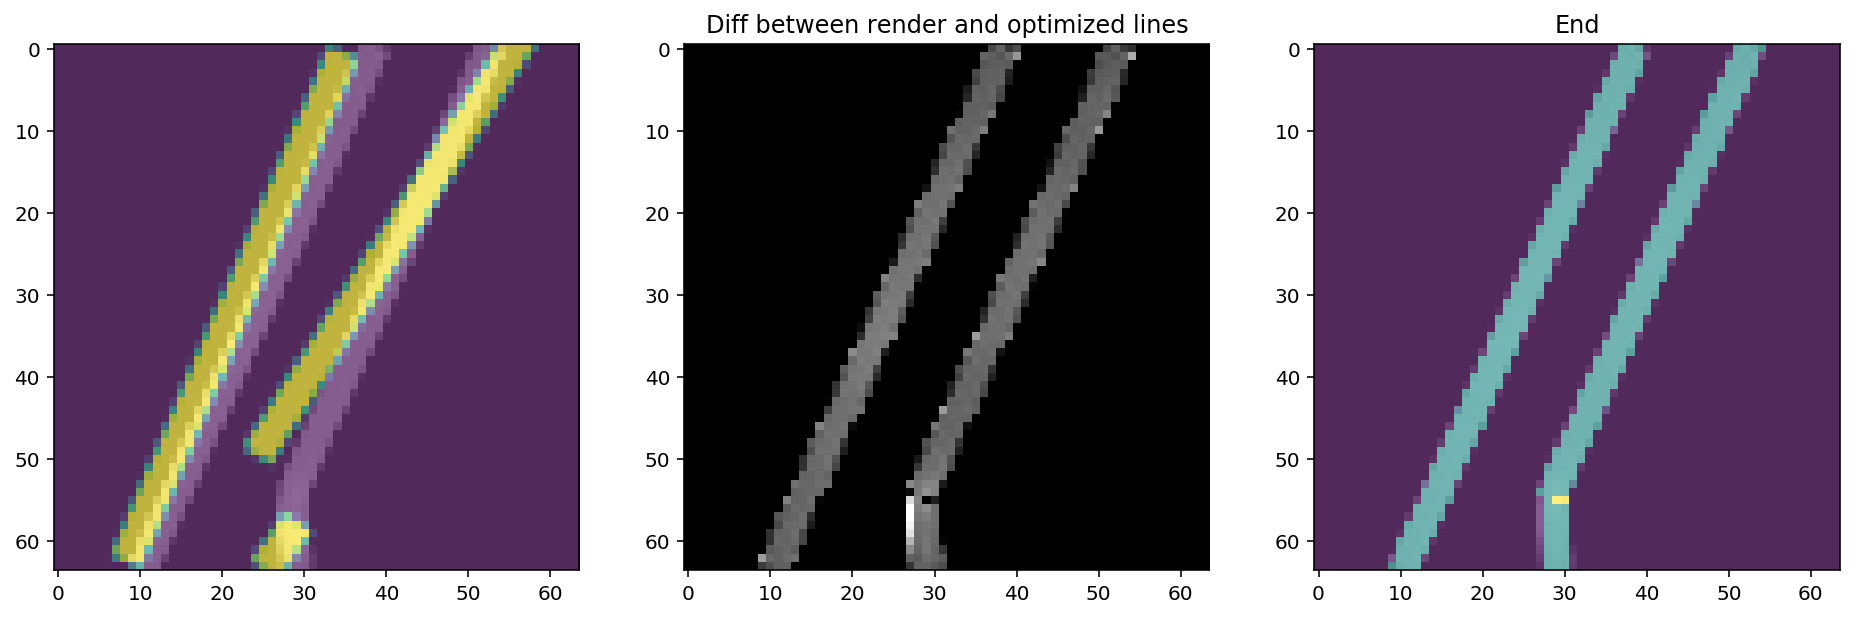

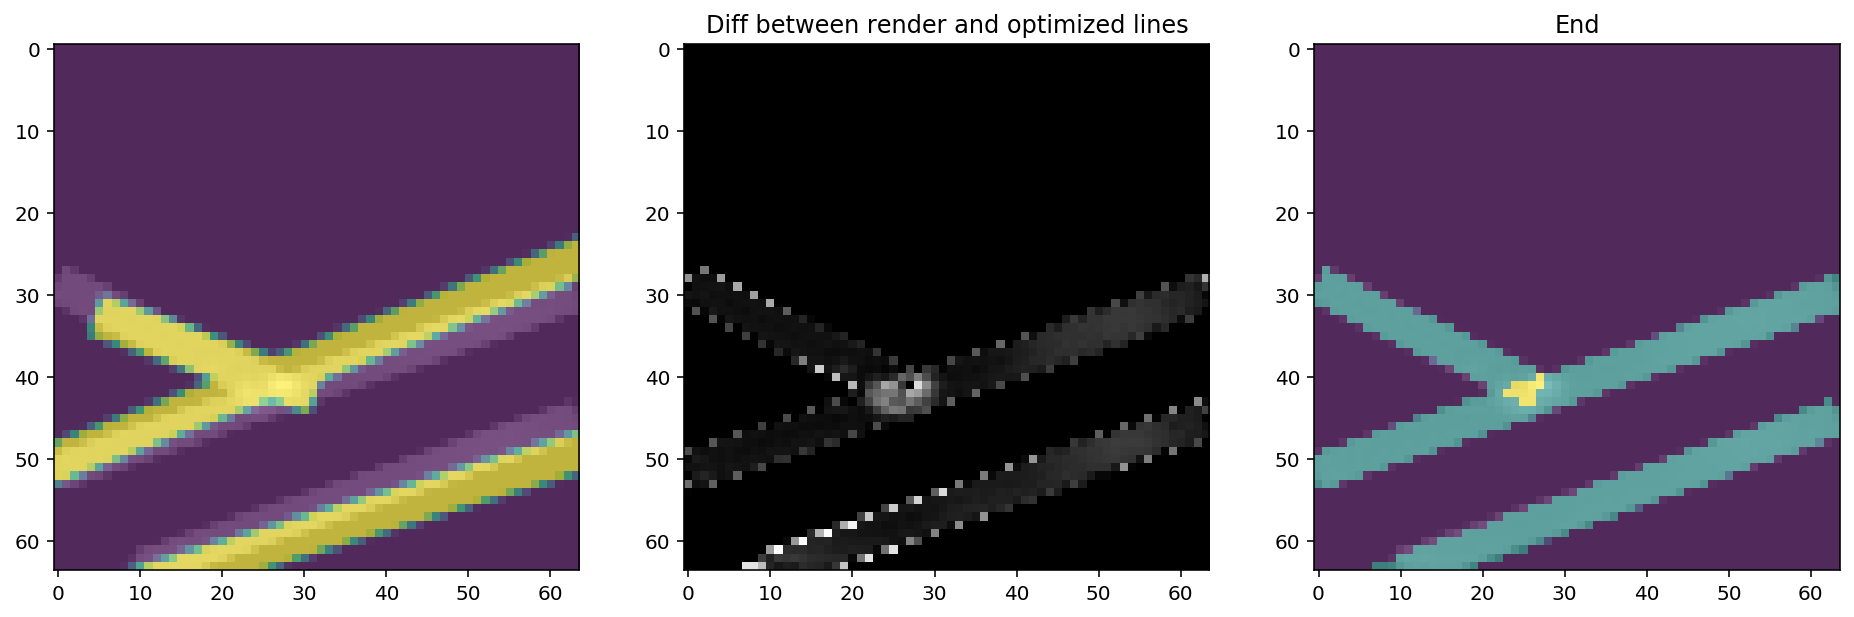

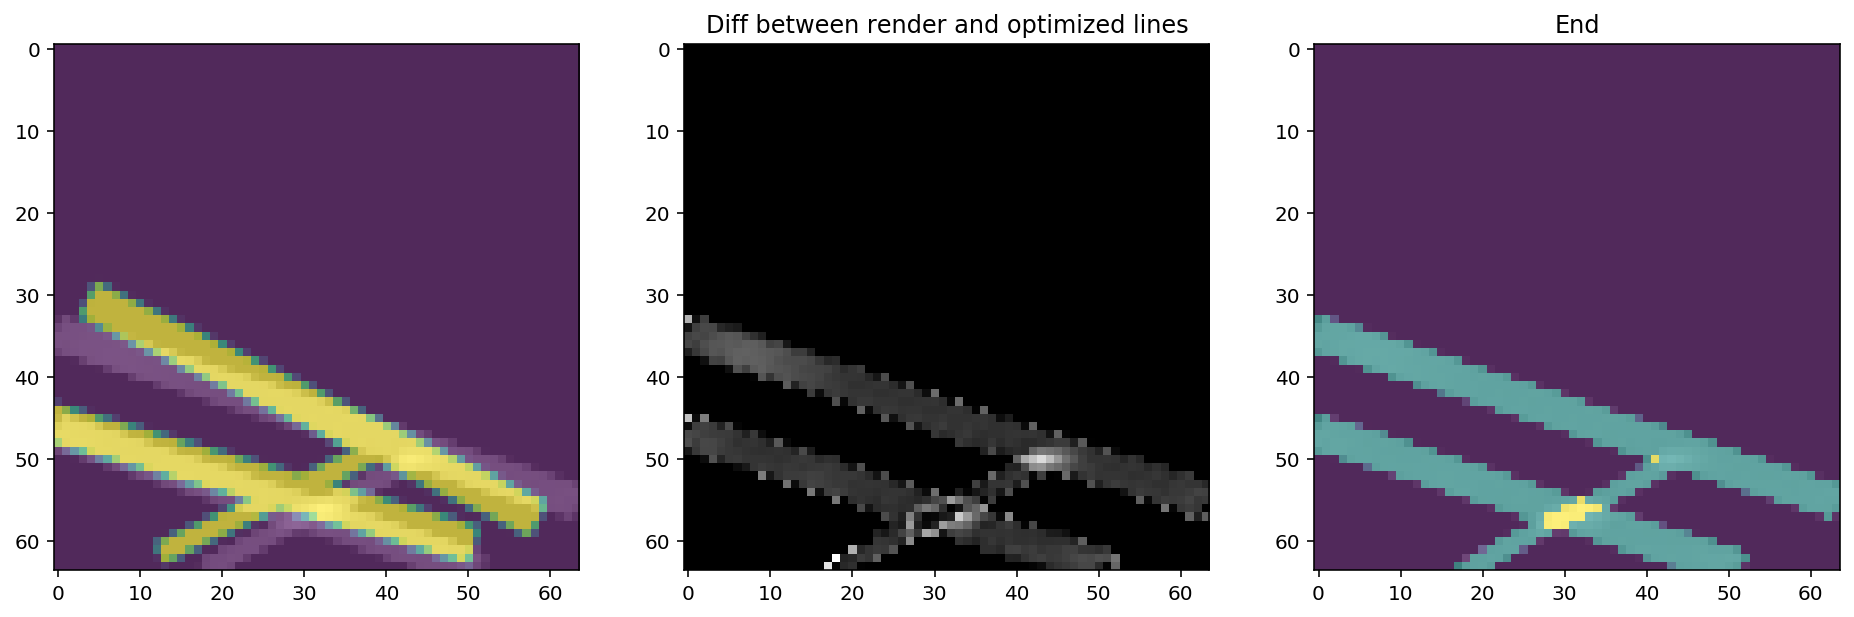

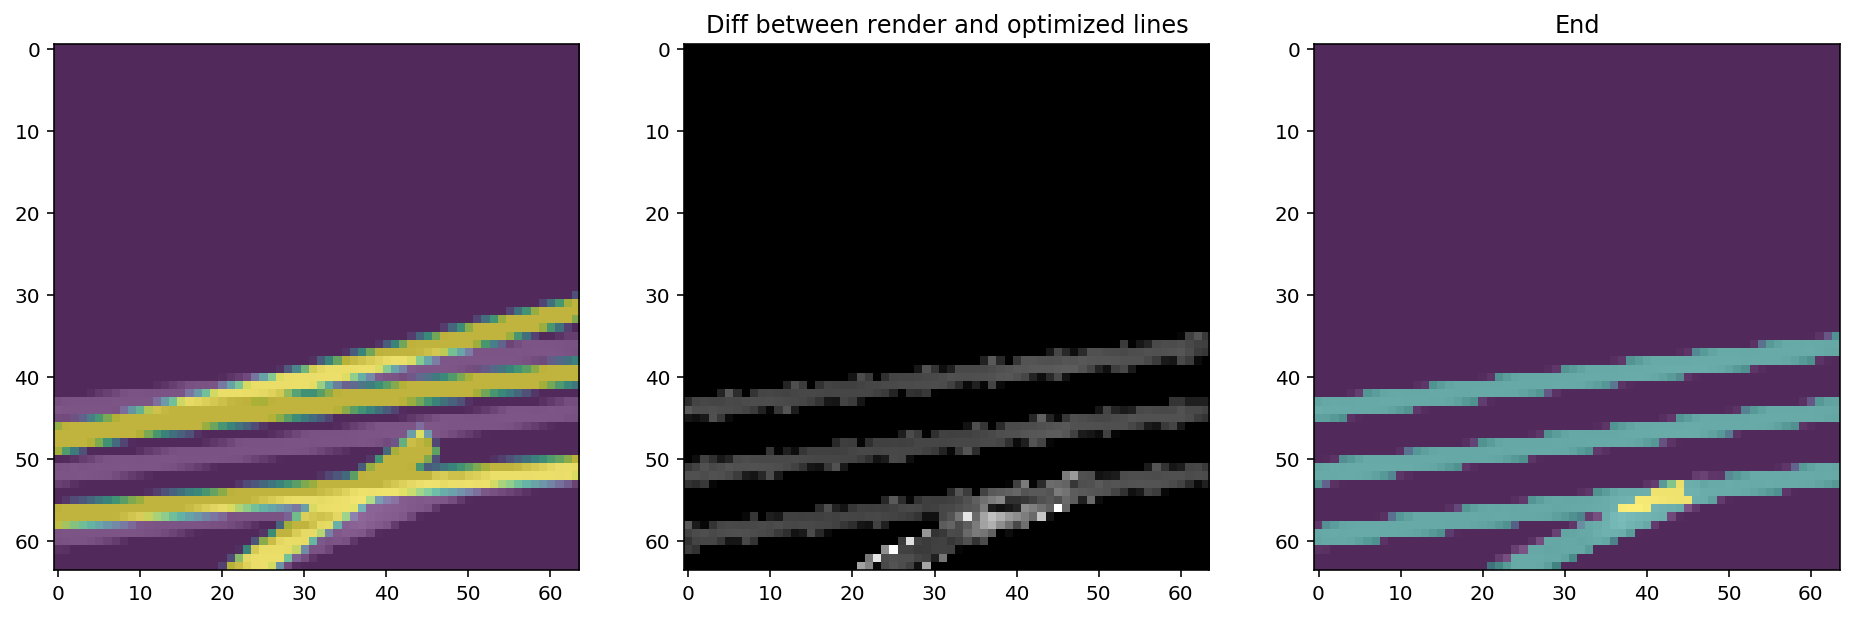

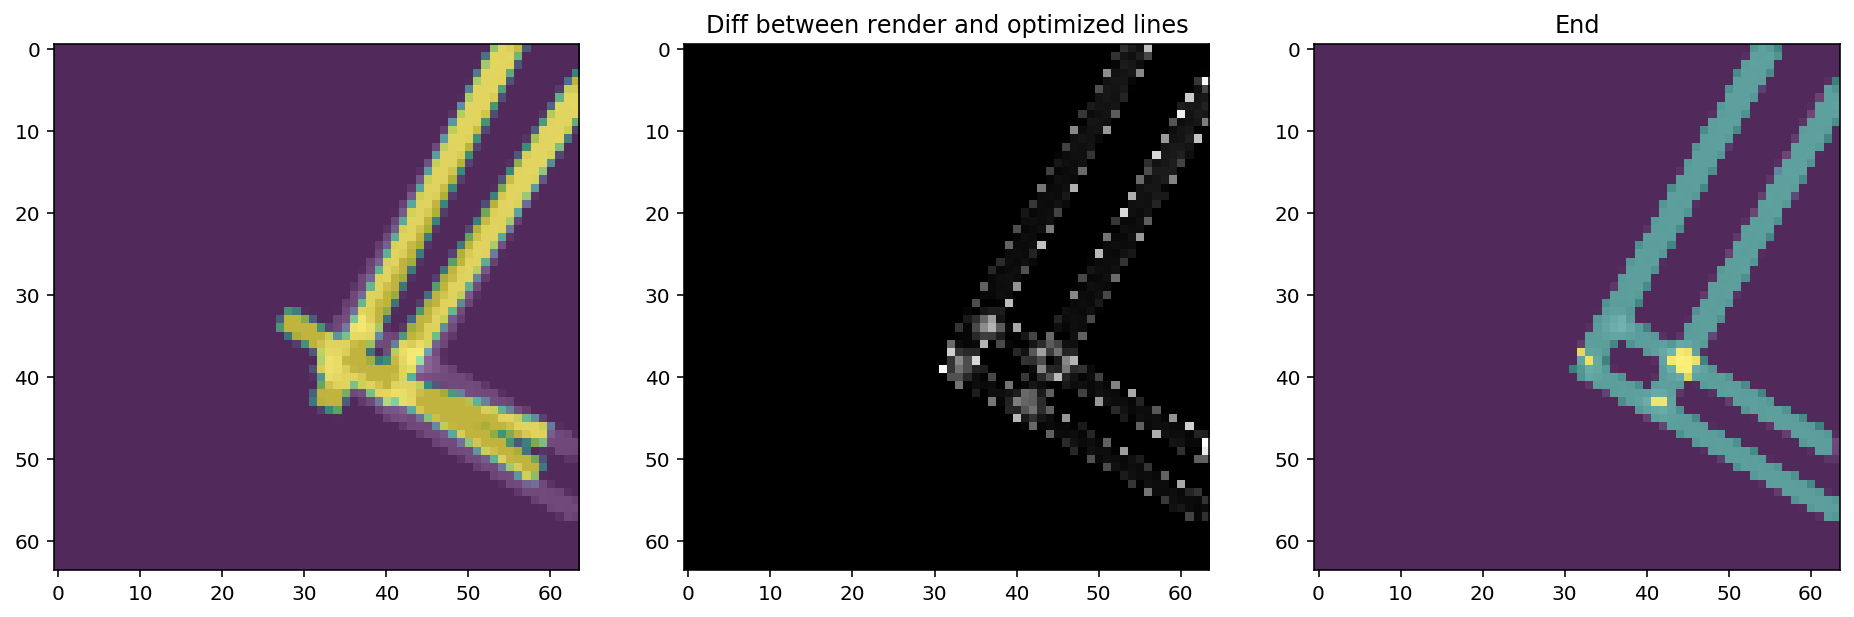

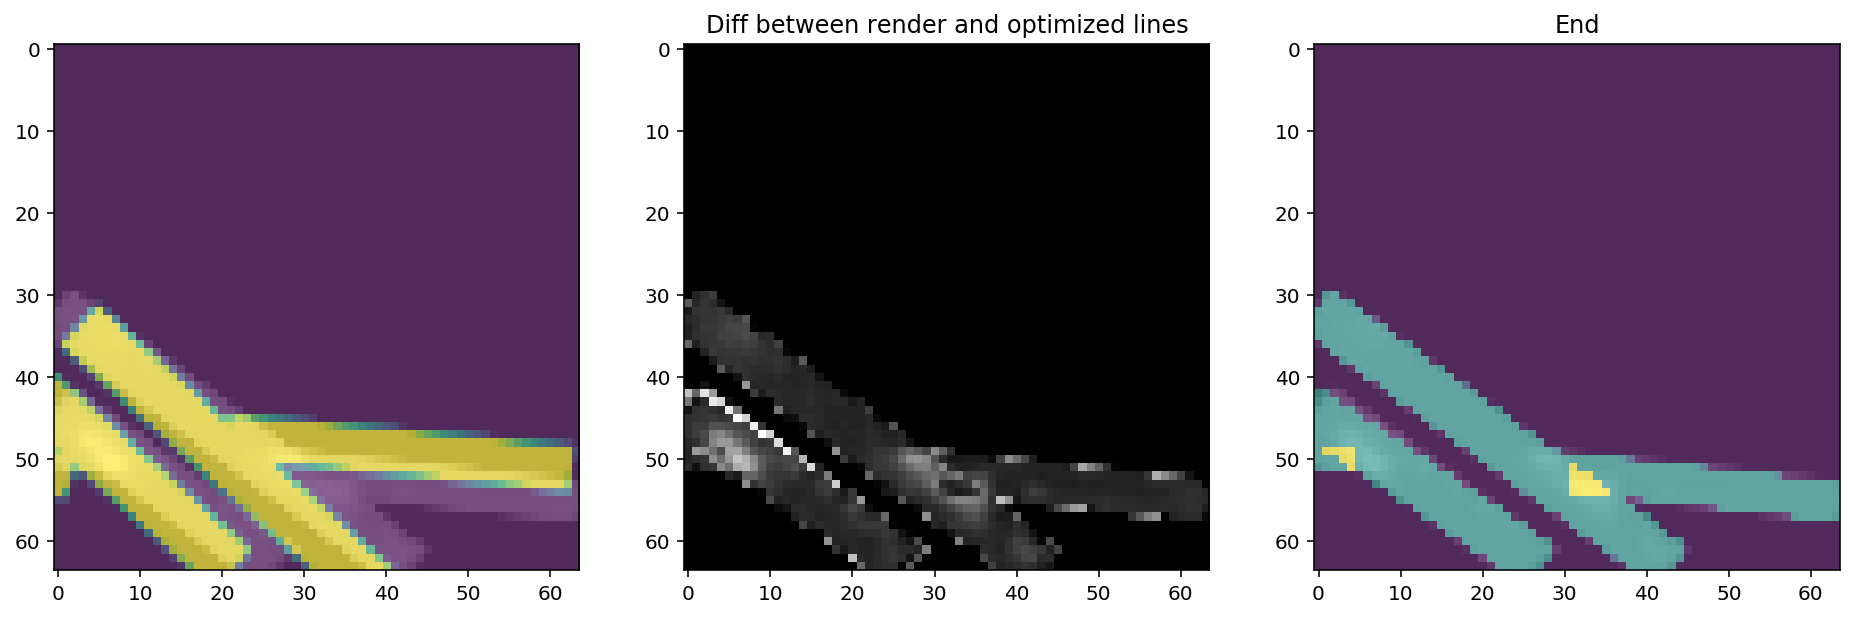

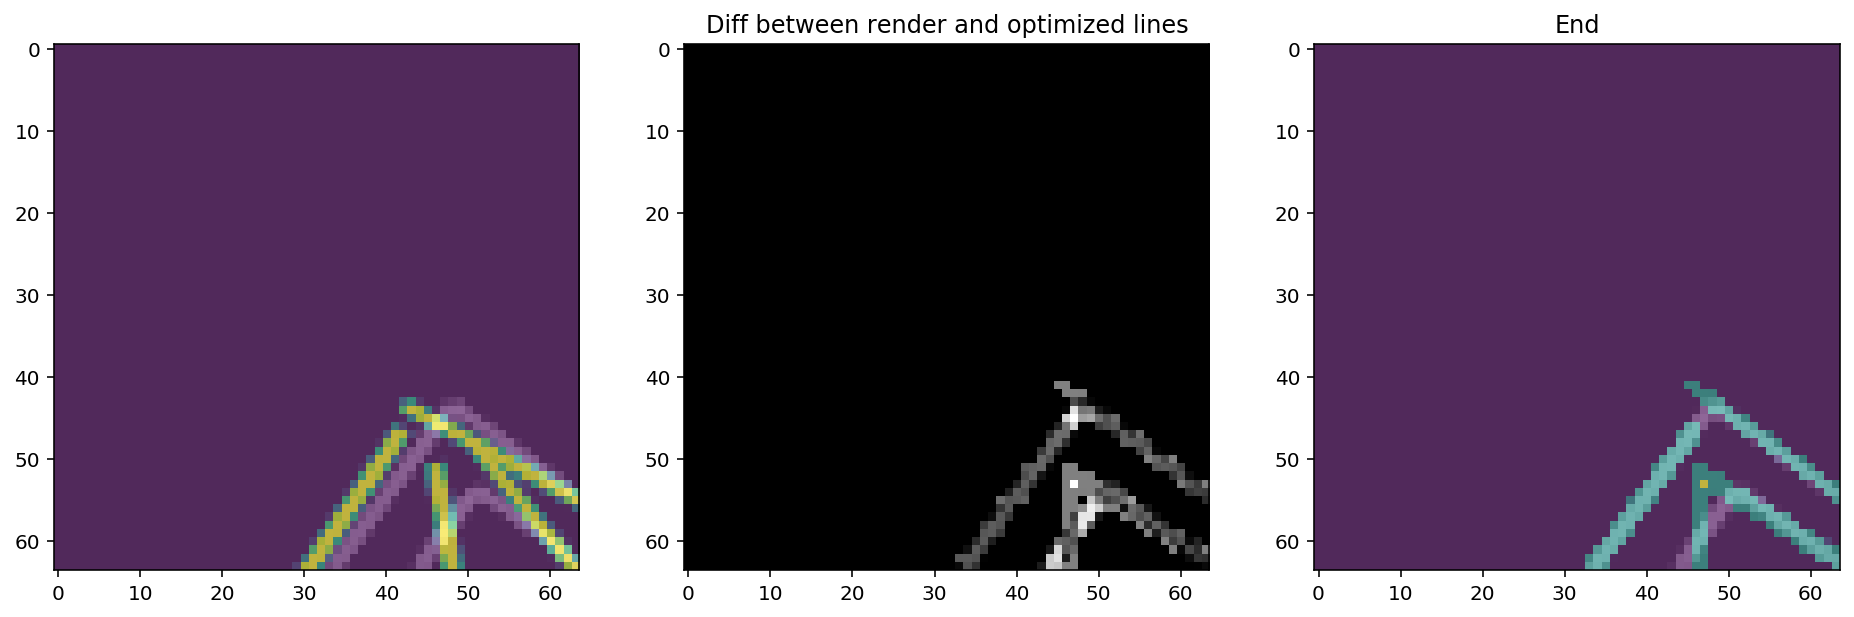

In [5]:
for i, (raster, render) in enumerate(zip(aligner.state['raster'], aligner.state['render'])):
    raster = raster.detach().cpu().numpy()
    render = render.detach().cpu().numpy()
    
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(raster, alpha=0.6, cmap='gray')
    initial = SyntheticPatch.from_lines(torch_to_synthetic_lines(aligner.state['initial_line_batch'][i].detach().cpu())).get_image()
    plt.imshow(initial, alpha=0.6)
    plt.subplot(1, 3, 2)
    plt.title('Diff between render and optimized lines')
    plt.imshow(np.abs(aligner.state['difference'][i].detach().cpu().numpy()), cmap='gray')
    plt.subplot(1, 3, 3)
    plt.imshow(raster, alpha=0.6, cmap='gray')
    plt.title('End')
    plt.imshow(aligner.state['render'][i].detach().cpu().numpy(), alpha=0.6)
    plt.show()

In [29]:
def make_animation(image, renders):
    fig = plt.figure()
    ims = []
    for i in range(len(renders)):
        background = plt.imshow(image, animated=True, alpha=0.6, cmap='gray')
        im = plt.imshow(renders[i], animated=True, alpha=0.6)
        ims.append([background, im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                    repeat_delay=1000)
    
    return ani

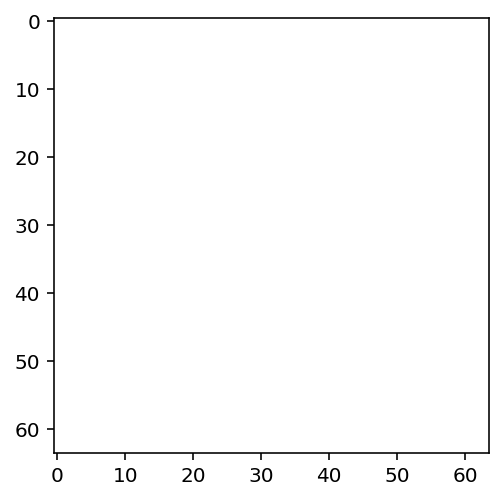

In [30]:
anim = make_animation(aligner.state['raster'][0].detach().cpu().numpy(), aligner.state['renders'])
HTML(anim.to_html5_video())